# Import

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

2022-03-10 09:22:28.665741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 09:22:28.665805: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# VAE Base Model

## Class Sampling

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Encoder

In [10]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_3[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_4[0][0]']               
                                                                                            

## Decoder

In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 1)        289 

## Define VAE as a Model

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train VAE Model

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=5, batch_size=128)

In [ ]:
mnist_digits.shape

## Display Sample

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)


## Latent Space Cluster

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)


# VAE Smile Model

## Class Sampling

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [3]:
latent_dim = 16

encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  


2022-03-09 21:57:44.058594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-09 21:57:44.058751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-09 21:57:44.058785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-09 21:57:44.058827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-09 21:57:44.058865: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

 conv2d_2 (Conv2D)              (None, 16, 16, 128)  73856       ['conv2d_1[0][0]']               
                                                                                                  
 flatten (Flatten)              (None, 32768)        0           ['conv2d_2[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 128)          4194432     ['flatten[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 16)           2064        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 16)           2064        ['dense[0][0]']                  
                                                                                                  
 sampling 

## Decoder

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 8192)              139264    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 32)       1846

## Define VAE as a Model

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_absolute_error(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Train Smile Model

## Get Data

In [6]:
from icangetyoursmile.utils import get_dataset_tts_from_local

In [7]:
path = "../../raw_data"

X, y, X_test, y_test, X_visu, y_visu = get_dataset_tts_from_local(path, image_size=(128,128), sample_size=2500)

Loading data from ../../raw_data/128x128/...
Done
X shape : (2125, 128, 128, 3)
y shape : (2125, 128, 128, 3)
X_test shape : (375, 128, 128, 3)
y_test shape : (375, 128, 128, 3)
X_visu shape : (5, 128, 128, 3)
y_visu shape : (5, 128, 128, 3)


In [9]:
X_st = y.astype("float32") / 255

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [11]:
vae

In [18]:
epochs = 2500
batch_size = 32

In [19]:
history = vae.fit(X_st, epochs=epochs, batch_size=batch_size)

Epoch 1/2500
67/67 [==============================] - 12s 184ms/step - loss: 1348.0131 - reconstruction_loss: 1300.4905 - kl_loss: 44.3437
Epoch 2/2500
67/67 [==============================] - 12s 183ms/step - loss: 1327.5495 - reconstruction_loss: 1285.1206 - kl_loss: 44.0334
Epoch 3/2500
67/67 [==============================] - 12s 183ms/step - loss: 1325.2993 - reconstruction_loss: 1282.9573 - kl_loss: 43.7509
Epoch 4/2500
67/67 [==============================] - 12s 181ms/step - loss: 1311.1169 - reconstruction_loss: 1262.7455 - kl_loss: 44.2684
Epoch 5/2500
67/67 [==============================] - 12s 182ms/step - loss: 1305.9429 - reconstruction_loss: 1262.1134 - kl_loss: 44.5868
Epoch 6/2500
67/67 [==============================] - 12s 186ms/step - loss: 1291.6022 - reconstruction_loss: 1245.8832 - kl_loss: 44.8554
Epoch 7/2500
67/67 [==============================] - 13s 190ms/step - loss: 1270.1165 - reconstruction_loss: 1232.2236 - kl_loss: 45.1385
Epoch 8/2500
67/67 [=======

67/67 [==============================] - 12s 185ms/step - loss: 993.6297 - reconstruction_loss: 949.9222 - kl_loss: 48.8263
Epoch 118/2500
67/67 [==============================] - 12s 185ms/step - loss: 997.5793 - reconstruction_loss: 947.0515 - kl_loss: 48.9345
Epoch 119/2500
67/67 [==============================] - 12s 186ms/step - loss: 999.6490 - reconstruction_loss: 950.6798 - kl_loss: 49.0565
Epoch 120/2500
67/67 [==============================] - 12s 185ms/step - loss: 996.4386 - reconstruction_loss: 952.8641 - kl_loss: 49.1800
Epoch 121/2500
67/67 [==============================] - 13s 187ms/step - loss: 989.0434 - reconstruction_loss: 949.3034 - kl_loss: 48.7116
Epoch 122/2500
67/67 [==============================] - 13s 193ms/step - loss: 995.4960 - reconstruction_loss: 947.1282 - kl_loss: 48.7786
Epoch 123/2500
67/67 [==============================] - 13s 188ms/step - loss: 985.2802 - reconstruction_loss: 943.6797 - kl_loss: 48.9625
Epoch 124/2500
67/67 [====================

67/67 [==============================] - 13s 187ms/step - loss: 948.3169 - reconstruction_loss: 905.3776 - kl_loss: 48.7620
Epoch 177/2500
67/67 [==============================] - 13s 189ms/step - loss: 949.1709 - reconstruction_loss: 906.9710 - kl_loss: 48.8912
Epoch 178/2500
67/67 [==============================] - 13s 188ms/step - loss: 944.1849 - reconstruction_loss: 903.3271 - kl_loss: 48.6173
Epoch 179/2500
67/67 [==============================] - 13s 199ms/step - loss: 951.7012 - reconstruction_loss: 906.1202 - kl_loss: 48.8350
Epoch 180/2500
67/67 [==============================] - 13s 191ms/step - loss: 945.6005 - reconstruction_loss: 901.0267 - kl_loss: 48.8700
Epoch 181/2500
67/67 [==============================] - 13s 189ms/step - loss: 953.3266 - reconstruction_loss: 901.7097 - kl_loss: 48.8847
Epoch 182/2500
67/67 [==============================] - 13s 189ms/step - loss: 950.3862 - reconstruction_loss: 900.2854 - kl_loss: 48.7840
Epoch 183/2500
67/67 [====================

67/67 [==============================] - 12s 183ms/step - loss: 920.9297 - reconstruction_loss: 879.7614 - kl_loss: 48.4534
Epoch 236/2500
67/67 [==============================] - 13s 194ms/step - loss: 930.4407 - reconstruction_loss: 882.9793 - kl_loss: 48.4525
Epoch 237/2500
67/67 [==============================] - 13s 187ms/step - loss: 925.8290 - reconstruction_loss: 875.0653 - kl_loss: 48.6327
Epoch 238/2500
67/67 [==============================] - 12s 185ms/step - loss: 924.2654 - reconstruction_loss: 876.2926 - kl_loss: 48.7080
Epoch 239/2500
67/67 [==============================] - 13s 190ms/step - loss: 925.4934 - reconstruction_loss: 877.4768 - kl_loss: 48.7422
Epoch 240/2500
67/67 [==============================] - 12s 184ms/step - loss: 919.3960 - reconstruction_loss: 879.8306 - kl_loss: 48.4919
Epoch 241/2500
67/67 [==============================] - 12s 185ms/step - loss: 925.5725 - reconstruction_loss: 881.1146 - kl_loss: 48.7125
Epoch 242/2500
67/67 [====================

67/67 [==============================] - 13s 192ms/step - loss: 902.9293 - reconstruction_loss: 860.5386 - kl_loss: 48.6922
Epoch 295/2500
67/67 [==============================] - 13s 187ms/step - loss: 895.7942 - reconstruction_loss: 854.2032 - kl_loss: 49.1274
Epoch 296/2500
67/67 [==============================] - 13s 187ms/step - loss: 892.4917 - reconstruction_loss: 851.2784 - kl_loss: 49.0190
Epoch 297/2500
67/67 [==============================] - 12s 186ms/step - loss: 892.2391 - reconstruction_loss: 850.5220 - kl_loss: 49.0408
Epoch 298/2500
67/67 [==============================] - 12s 186ms/step - loss: 895.3920 - reconstruction_loss: 851.7514 - kl_loss: 49.0702
Epoch 299/2500
67/67 [==============================] - 12s 184ms/step - loss: 901.7416 - reconstruction_loss: 852.2267 - kl_loss: 48.7865
Epoch 300/2500
67/67 [==============================] - 12s 186ms/step - loss: 902.5041 - reconstruction_loss: 858.6897 - kl_loss: 48.7741
Epoch 301/2500
67/67 [====================

67/67 [==============================] - 12s 186ms/step - loss: 894.6513 - reconstruction_loss: 842.0018 - kl_loss: 49.2088
Epoch 354/2500
67/67 [==============================] - 12s 184ms/step - loss: 886.6484 - reconstruction_loss: 841.1674 - kl_loss: 48.9595
Epoch 355/2500
67/67 [==============================] - 12s 185ms/step - loss: 890.0470 - reconstruction_loss: 844.1534 - kl_loss: 49.1427
Epoch 356/2500
67/67 [==============================] - 13s 187ms/step - loss: 884.6986 - reconstruction_loss: 840.9319 - kl_loss: 49.1180
Epoch 357/2500
67/67 [==============================] - 13s 187ms/step - loss: 889.3116 - reconstruction_loss: 843.1871 - kl_loss: 48.9647
Epoch 358/2500
67/67 [==============================] - 13s 187ms/step - loss: 883.8015 - reconstruction_loss: 841.8408 - kl_loss: 48.7591
Epoch 359/2500
67/67 [==============================] - 13s 189ms/step - loss: 883.7259 - reconstruction_loss: 837.4991 - kl_loss: 49.2888
Epoch 360/2500
67/67 [====================

67/67 [==============================] - 13s 187ms/step - loss: 883.9711 - reconstruction_loss: 831.5983 - kl_loss: 49.1678
Epoch 413/2500
67/67 [==============================] - 12s 186ms/step - loss: 875.1079 - reconstruction_loss: 831.2871 - kl_loss: 49.0954
Epoch 414/2500
67/67 [==============================] - 13s 187ms/step - loss: 876.6747 - reconstruction_loss: 827.3431 - kl_loss: 49.1621
Epoch 415/2500
67/67 [==============================] - 13s 192ms/step - loss: 879.9091 - reconstruction_loss: 829.4968 - kl_loss: 49.2337
Epoch 416/2500
67/67 [==============================] - 13s 199ms/step - loss: 872.0942 - reconstruction_loss: 826.9749 - kl_loss: 49.0068
Epoch 417/2500
67/67 [==============================] - 14s 202ms/step - loss: 873.1133 - reconstruction_loss: 827.9025 - kl_loss: 49.2490
Epoch 418/2500
67/67 [==============================] - 12s 187ms/step - loss: 877.7126 - reconstruction_loss: 830.8930 - kl_loss: 48.9680
Epoch 419/2500
67/67 [====================

67/67 [==============================] - 12s 184ms/step - loss: 865.2930 - reconstruction_loss: 817.3044 - kl_loss: 49.2380
Epoch 472/2500
67/67 [==============================] - 12s 185ms/step - loss: 861.1851 - reconstruction_loss: 816.5499 - kl_loss: 49.1121
Epoch 473/2500
67/67 [==============================] - 13s 189ms/step - loss: 860.3873 - reconstruction_loss: 818.4222 - kl_loss: 49.0864
Epoch 474/2500
67/67 [==============================] - 13s 195ms/step - loss: 865.0467 - reconstruction_loss: 816.8971 - kl_loss: 49.1647
Epoch 475/2500
67/67 [==============================] - 13s 187ms/step - loss: 863.1268 - reconstruction_loss: 816.6916 - kl_loss: 49.3834
Epoch 476/2500
67/67 [==============================] - 12s 186ms/step - loss: 865.0707 - reconstruction_loss: 821.1314 - kl_loss: 49.2441
Epoch 477/2500
67/67 [==============================] - 13s 189ms/step - loss: 861.2716 - reconstruction_loss: 817.3146 - kl_loss: 49.3064
Epoch 478/2500
67/67 [====================

67/67 [==============================] - 13s 194ms/step - loss: 851.2899 - reconstruction_loss: 810.9524 - kl_loss: 49.2451
Epoch 531/2500
67/67 [==============================] - 13s 196ms/step - loss: 858.1082 - reconstruction_loss: 815.9562 - kl_loss: 49.1160
Epoch 532/2500
67/67 [==============================] - 13s 188ms/step - loss: 854.5964 - reconstruction_loss: 817.4490 - kl_loss: 48.8292
Epoch 533/2500
67/67 [==============================] - 12s 186ms/step - loss: 868.2509 - reconstruction_loss: 820.8855 - kl_loss: 48.8254
Epoch 534/2500
67/67 [==============================] - 13s 187ms/step - loss: 862.3843 - reconstruction_loss: 815.5257 - kl_loss: 48.8975
Epoch 535/2500
67/67 [==============================] - 12s 186ms/step - loss: 864.0796 - reconstruction_loss: 810.0671 - kl_loss: 49.0454
Epoch 536/2500
67/67 [==============================] - 13s 188ms/step - loss: 852.6253 - reconstruction_loss: 808.0261 - kl_loss: 49.3902
Epoch 537/2500
67/67 [====================

67/67 [==============================] - 13s 187ms/step - loss: 844.3349 - reconstruction_loss: 799.8214 - kl_loss: 49.3804
Epoch 590/2500
67/67 [==============================] - 12s 184ms/step - loss: 840.0911 - reconstruction_loss: 801.2697 - kl_loss: 49.3062
Epoch 591/2500
67/67 [==============================] - 12s 185ms/step - loss: 850.5329 - reconstruction_loss: 804.4577 - kl_loss: 49.1490
Epoch 592/2500
67/67 [==============================] - 12s 186ms/step - loss: 849.3353 - reconstruction_loss: 802.3886 - kl_loss: 49.1209
Epoch 593/2500
67/67 [==============================] - 13s 188ms/step - loss: 848.8795 - reconstruction_loss: 803.2421 - kl_loss: 49.0476
Epoch 594/2500
67/67 [==============================] - 13s 188ms/step - loss: 852.6525 - reconstruction_loss: 805.5380 - kl_loss: 49.0566
Epoch 595/2500
67/67 [==============================] - 13s 191ms/step - loss: 851.6729 - reconstruction_loss: 805.0480 - kl_loss: 49.1780
Epoch 596/2500
67/67 [====================

67/67 [==============================] - 13s 190ms/step - loss: 846.3266 - reconstruction_loss: 796.1963 - kl_loss: 49.0054
Epoch 649/2500
67/67 [==============================] - 12s 186ms/step - loss: 844.1916 - reconstruction_loss: 798.5883 - kl_loss: 49.0510
Epoch 650/2500
67/67 [==============================] - 12s 186ms/step - loss: 844.6447 - reconstruction_loss: 799.8091 - kl_loss: 49.0863
Epoch 651/2500
67/67 [==============================] - 13s 187ms/step - loss: 847.0588 - reconstruction_loss: 801.5157 - kl_loss: 48.9303
Epoch 652/2500
67/67 [==============================] - 13s 187ms/step - loss: 848.5078 - reconstruction_loss: 800.2170 - kl_loss: 48.9666
Epoch 653/2500
67/67 [==============================] - 13s 189ms/step - loss: 852.5395 - reconstruction_loss: 801.0601 - kl_loss: 48.9072
Epoch 654/2500
67/67 [==============================] - 13s 198ms/step - loss: 841.5772 - reconstruction_loss: 797.7325 - kl_loss: 49.0998
Epoch 655/2500
67/67 [====================

67/67 [==============================] - 13s 187ms/step - loss: 848.2116 - reconstruction_loss: 798.1530 - kl_loss: 48.7024
Epoch 708/2500
67/67 [==============================] - 13s 187ms/step - loss: 844.0063 - reconstruction_loss: 795.7724 - kl_loss: 48.6415
Epoch 709/2500
67/67 [==============================] - 12s 185ms/step - loss: 842.7736 - reconstruction_loss: 796.4283 - kl_loss: 48.6718
Epoch 710/2500
67/67 [==============================] - 13s 190ms/step - loss: 831.6577 - reconstruction_loss: 790.5316 - kl_loss: 48.6866
Epoch 711/2500
67/67 [==============================] - 13s 194ms/step - loss: 841.7378 - reconstruction_loss: 796.2026 - kl_loss: 48.6196
Epoch 712/2500
67/67 [==============================] - 13s 188ms/step - loss: 842.4256 - reconstruction_loss: 799.7413 - kl_loss: 48.3430
Epoch 713/2500
67/67 [==============================] - 12s 185ms/step - loss: 843.8318 - reconstruction_loss: 793.5696 - kl_loss: 48.5148
Epoch 714/2500
67/67 [====================

67/67 [==============================] - 13s 189ms/step - loss: 841.8024 - reconstruction_loss: 792.3705 - kl_loss: 47.7282
Epoch 767/2500
67/67 [==============================] - 13s 192ms/step - loss: 836.6194 - reconstruction_loss: 791.6874 - kl_loss: 47.7892
Epoch 768/2500
67/67 [==============================] - 13s 198ms/step - loss: 835.0632 - reconstruction_loss: 790.6407 - kl_loss: 47.8853
Epoch 769/2500
67/67 [==============================] - 13s 189ms/step - loss: 826.9104 - reconstruction_loss: 788.9038 - kl_loss: 47.8568
Epoch 770/2500
67/67 [==============================] - 13s 188ms/step - loss: 835.5122 - reconstruction_loss: 790.5803 - kl_loss: 47.7376
Epoch 771/2500
67/67 [==============================] - 13s 187ms/step - loss: 835.1679 - reconstruction_loss: 790.6099 - kl_loss: 47.6790
Epoch 772/2500
67/67 [==============================] - 12s 186ms/step - loss: 830.9669 - reconstruction_loss: 788.2760 - kl_loss: 47.8626
Epoch 773/2500
67/67 [====================

67/67 [==============================] - 13s 195ms/step - loss: 830.4049 - reconstruction_loss: 786.2599 - kl_loss: 47.5967
Epoch 826/2500
67/67 [==============================] - 13s 190ms/step - loss: 834.9151 - reconstruction_loss: 791.7855 - kl_loss: 47.5926
Epoch 827/2500
67/67 [==============================] - 13s 188ms/step - loss: 830.8581 - reconstruction_loss: 788.0406 - kl_loss: 47.7605
Epoch 828/2500
67/67 [==============================] - 13s 191ms/step - loss: 832.0232 - reconstruction_loss: 785.3244 - kl_loss: 47.7396
Epoch 829/2500
67/67 [==============================] - 13s 189ms/step - loss: 832.7341 - reconstruction_loss: 785.0887 - kl_loss: 47.6846
Epoch 830/2500
67/67 [==============================] - 12s 185ms/step - loss: 828.1791 - reconstruction_loss: 786.5187 - kl_loss: 47.8100
Epoch 831/2500
67/67 [==============================] - 12s 185ms/step - loss: 831.7275 - reconstruction_loss: 786.2002 - kl_loss: 47.6829
Epoch 832/2500
67/67 [====================

67/67 [==============================] - 12s 183ms/step - loss: 828.6747 - reconstruction_loss: 784.4855 - kl_loss: 47.8615
Epoch 885/2500
67/67 [==============================] - 12s 184ms/step - loss: 825.6979 - reconstruction_loss: 783.6904 - kl_loss: 47.6236
Epoch 886/2500
67/67 [==============================] - 12s 185ms/step - loss: 828.5793 - reconstruction_loss: 781.5262 - kl_loss: 47.7136
Epoch 887/2500
67/67 [==============================] - 13s 188ms/step - loss: 823.3950 - reconstruction_loss: 778.2637 - kl_loss: 47.8103
Epoch 888/2500
67/67 [==============================] - 12s 185ms/step - loss: 822.3973 - reconstruction_loss: 779.6752 - kl_loss: 47.8224
Epoch 889/2500
67/67 [==============================] - 12s 182ms/step - loss: 829.9003 - reconstruction_loss: 787.8542 - kl_loss: 47.6898
Epoch 890/2500
67/67 [==============================] - 12s 185ms/step - loss: 825.5315 - reconstruction_loss: 781.9954 - kl_loss: 47.6726
Epoch 891/2500
67/67 [====================

67/67 [==============================] - 12s 184ms/step - loss: 817.8127 - reconstruction_loss: 778.8185 - kl_loss: 47.8761
Epoch 944/2500
67/67 [==============================] - 13s 187ms/step - loss: 824.1829 - reconstruction_loss: 778.0716 - kl_loss: 47.7066
Epoch 945/2500
67/67 [==============================] - 12s 183ms/step - loss: 836.6692 - reconstruction_loss: 786.1361 - kl_loss: 47.7411
Epoch 946/2500
67/67 [==============================] - 13s 187ms/step - loss: 826.3829 - reconstruction_loss: 780.0243 - kl_loss: 47.9182
Epoch 947/2500
67/67 [==============================] - 13s 188ms/step - loss: 825.7170 - reconstruction_loss: 784.0895 - kl_loss: 47.6742
Epoch 948/2500
67/67 [==============================] - 13s 188ms/step - loss: 828.4552 - reconstruction_loss: 785.5623 - kl_loss: 47.7629
Epoch 949/2500
67/67 [==============================] - 13s 195ms/step - loss: 822.8853 - reconstruction_loss: 781.8287 - kl_loss: 47.6488
Epoch 950/2500
67/67 [====================

67/67 [==============================] - 12s 186ms/step - loss: 820.0309 - reconstruction_loss: 775.3120 - kl_loss: 47.6745
Epoch 1003/2500
67/67 [==============================] - 12s 186ms/step - loss: 822.5764 - reconstruction_loss: 773.9539 - kl_loss: 47.8269
Epoch 1004/2500
67/67 [==============================] - 12s 186ms/step - loss: 827.0572 - reconstruction_loss: 779.3655 - kl_loss: 47.7783
Epoch 1005/2500
67/67 [==============================] - 13s 187ms/step - loss: 823.5818 - reconstruction_loss: 777.1624 - kl_loss: 47.8326
Epoch 1006/2500
67/67 [==============================] - 13s 195ms/step - loss: 819.7372 - reconstruction_loss: 775.2027 - kl_loss: 47.7970
Epoch 1007/2500
67/67 [==============================] - 13s 191ms/step - loss: 813.9740 - reconstruction_loss: 774.9041 - kl_loss: 47.8990
Epoch 1008/2500
67/67 [==============================] - 13s 189ms/step - loss: 814.7725 - reconstruction_loss: 775.3347 - kl_loss: 47.8202
Epoch 1009/2500
67/67 [=============

67/67 [==============================] - 12s 185ms/step - loss: 815.5896 - reconstruction_loss: 773.5468 - kl_loss: 47.8896
Epoch 1119/2500
67/67 [==============================] - 13s 190ms/step - loss: 817.0190 - reconstruction_loss: 770.0182 - kl_loss: 47.9920
Epoch 1120/2500
67/67 [==============================] - 13s 197ms/step - loss: 813.7870 - reconstruction_loss: 772.2111 - kl_loss: 47.9211
Epoch 1121/2500
67/67 [==============================] - 13s 198ms/step - loss: 819.2258 - reconstruction_loss: 772.5818 - kl_loss: 47.8028
Epoch 1122/2500
67/67 [==============================] - 13s 188ms/step - loss: 816.2847 - reconstruction_loss: 776.2511 - kl_loss: 47.8995
Epoch 1123/2500
67/67 [==============================] - 13s 187ms/step - loss: 823.0499 - reconstruction_loss: 780.2684 - kl_loss: 47.8894
Epoch 1124/2500
67/67 [==============================] - 13s 189ms/step - loss: 823.2530 - reconstruction_loss: 771.3692 - kl_loss: 47.7638
Epoch 1125/2500
67/67 [=============

67/67 [==============================] - 13s 188ms/step - loss: 813.4350 - reconstruction_loss: 770.1526 - kl_loss: 47.9791
Epoch 1235/2500
67/67 [==============================] - 13s 195ms/step - loss: 827.4868 - reconstruction_loss: 780.1063 - kl_loss: 47.9492
Epoch 1236/2500
67/67 [==============================] - 13s 189ms/step - loss: 822.3242 - reconstruction_loss: 768.8101 - kl_loss: 48.0078
Epoch 1237/2500
67/67 [==============================] - 12s 186ms/step - loss: 816.9738 - reconstruction_loss: 766.5663 - kl_loss: 47.7342
Epoch 1238/2500
67/67 [==============================] - 12s 186ms/step - loss: 809.4810 - reconstruction_loss: 767.6812 - kl_loss: 48.0440
Epoch 1239/2500
67/67 [==============================] - 12s 185ms/step - loss: 815.8655 - reconstruction_loss: 767.2227 - kl_loss: 47.9610
Epoch 1240/2500
67/67 [==============================] - 12s 184ms/step - loss: 807.9483 - reconstruction_loss: 766.4748 - kl_loss: 48.0792
Epoch 1241/2500
67/67 [=============

67/67 [==============================] - 13s 194ms/step - loss: 807.5024 - reconstruction_loss: 769.4615 - kl_loss: 48.1783
Epoch 1351/2500
67/67 [==============================] - 13s 187ms/step - loss: 812.2807 - reconstruction_loss: 765.0307 - kl_loss: 47.9647
Epoch 1352/2500
67/67 [==============================] - 13s 188ms/step - loss: 809.1514 - reconstruction_loss: 762.5715 - kl_loss: 47.9972
Epoch 1353/2500
67/67 [==============================] - 13s 187ms/step - loss: 811.2538 - reconstruction_loss: 761.8109 - kl_loss: 48.1582
Epoch 1354/2500
67/67 [==============================] - 12s 186ms/step - loss: 807.0856 - reconstruction_loss: 765.6048 - kl_loss: 48.0262
Epoch 1355/2500
67/67 [==============================] - 12s 185ms/step - loss: 806.8335 - reconstruction_loss: 761.4499 - kl_loss: 48.0431
Epoch 1356/2500
67/67 [==============================] - 12s 184ms/step - loss: 813.6331 - reconstruction_loss: 765.4982 - kl_loss: 47.9825
Epoch 1357/2500
67/67 [=============

67/67 [==============================] - 13s 191ms/step - loss: 810.9386 - reconstruction_loss: 759.4631 - kl_loss: 48.3807
Epoch 1467/2500
67/67 [==============================] - 12s 186ms/step - loss: 802.2462 - reconstruction_loss: 758.6143 - kl_loss: 48.2215
Epoch 1468/2500
67/67 [==============================] - 12s 185ms/step - loss: 804.5558 - reconstruction_loss: 759.4203 - kl_loss: 48.0493
Epoch 1469/2500
67/67 [==============================] - 12s 184ms/step - loss: 808.5597 - reconstruction_loss: 761.2286 - kl_loss: 48.1531
Epoch 1470/2500
67/67 [==============================] - 12s 186ms/step - loss: 813.2363 - reconstruction_loss: 761.4324 - kl_loss: 48.1619
Epoch 1471/2500
67/67 [==============================] - 12s 184ms/step - loss: 806.4449 - reconstruction_loss: 763.0123 - kl_loss: 48.1793
Epoch 1472/2500
67/67 [==============================] - 12s 183ms/step - loss: 809.9015 - reconstruction_loss: 761.5425 - kl_loss: 48.1336
Epoch 1473/2500
67/67 [=============

67/67 [==============================] - 12s 186ms/step - loss: 805.0486 - reconstruction_loss: 760.4145 - kl_loss: 48.1409
Epoch 1583/2500
67/67 [==============================] - 12s 186ms/step - loss: 808.6113 - reconstruction_loss: 760.7709 - kl_loss: 48.0821
Epoch 1584/2500
67/67 [==============================] - 12s 185ms/step - loss: 801.8828 - reconstruction_loss: 756.6882 - kl_loss: 48.0922
Epoch 1585/2500
67/67 [==============================] - 12s 183ms/step - loss: 805.5065 - reconstruction_loss: 764.5732 - kl_loss: 48.1656
Epoch 1586/2500
67/67 [==============================] - 12s 187ms/step - loss: 807.6154 - reconstruction_loss: 757.5844 - kl_loss: 48.2142
Epoch 1587/2500
67/67 [==============================] - 13s 191ms/step - loss: 806.2927 - reconstruction_loss: 757.9182 - kl_loss: 47.9822
Epoch 1588/2500
67/67 [==============================] - 13s 199ms/step - loss: 805.4140 - reconstruction_loss: 756.0485 - kl_loss: 48.1597
Epoch 1589/2500
67/67 [=============

67/67 [==============================] - 12s 183ms/step - loss: 798.2377 - reconstruction_loss: 754.2332 - kl_loss: 48.1746
Epoch 1699/2500
67/67 [==============================] - 12s 185ms/step - loss: 801.1402 - reconstruction_loss: 753.6132 - kl_loss: 48.0789
Epoch 1700/2500
67/67 [==============================] - 12s 182ms/step - loss: 799.3145 - reconstruction_loss: 753.4271 - kl_loss: 48.1136
Epoch 1701/2500
67/67 [==============================] - 12s 183ms/step - loss: 806.7032 - reconstruction_loss: 753.5157 - kl_loss: 48.2435
Epoch 1702/2500
67/67 [==============================] - 12s 185ms/step - loss: 799.5233 - reconstruction_loss: 753.7141 - kl_loss: 48.1781
Epoch 1703/2500
67/67 [==============================] - 13s 194ms/step - loss: 804.5765 - reconstruction_loss: 752.6290 - kl_loss: 48.1724
Epoch 1704/2500
67/67 [==============================] - 13s 189ms/step - loss: 798.8189 - reconstruction_loss: 754.4109 - kl_loss: 48.2154
Epoch 1705/2500
67/67 [=============

67/67 [==============================] - 12s 184ms/step - loss: 794.8897 - reconstruction_loss: 753.1366 - kl_loss: 48.0948
Epoch 1815/2500
67/67 [==============================] - 12s 185ms/step - loss: 792.6656 - reconstruction_loss: 749.3503 - kl_loss: 48.1837
Epoch 1816/2500
67/67 [==============================] - 12s 184ms/step - loss: 797.7124 - reconstruction_loss: 751.8114 - kl_loss: 48.3343
Epoch 1817/2500
67/67 [==============================] - 12s 184ms/step - loss: 800.1379 - reconstruction_loss: 756.8659 - kl_loss: 48.1203
Epoch 1818/2500
67/67 [==============================] - 13s 193ms/step - loss: 798.3440 - reconstruction_loss: 751.9160 - kl_loss: 48.1572
Epoch 1819/2500
67/67 [==============================] - 13s 188ms/step - loss: 803.7656 - reconstruction_loss: 752.8497 - kl_loss: 48.2283
Epoch 1820/2500
67/67 [==============================] - 12s 183ms/step - loss: 794.1860 - reconstruction_loss: 751.3730 - kl_loss: 48.2780
Epoch 1821/2500
67/67 [=============

67/67 [==============================] - 12s 184ms/step - loss: 810.4124 - reconstruction_loss: 755.9779 - kl_loss: 48.1030
Epoch 1931/2500
67/67 [==============================] - 12s 185ms/step - loss: 796.2826 - reconstruction_loss: 748.7242 - kl_loss: 48.0736
Epoch 1932/2500
67/67 [==============================] - 12s 184ms/step - loss: 797.7536 - reconstruction_loss: 748.8807 - kl_loss: 48.2704
Epoch 1933/2500
67/67 [==============================] - 13s 190ms/step - loss: 797.1481 - reconstruction_loss: 748.6738 - kl_loss: 48.4198
Epoch 1934/2500
67/67 [==============================] - 13s 191ms/step - loss: 794.8364 - reconstruction_loss: 749.9047 - kl_loss: 48.1264
Epoch 1935/2500
67/67 [==============================] - 12s 186ms/step - loss: 795.7387 - reconstruction_loss: 750.7376 - kl_loss: 48.0248
Epoch 1936/2500
67/67 [==============================] - 12s 185ms/step - loss: 790.6770 - reconstruction_loss: 749.1664 - kl_loss: 48.2372
Epoch 1937/2500
67/67 [=============

67/67 [==============================] - 12s 186ms/step - loss: 792.8784 - reconstruction_loss: 747.8607 - kl_loss: 48.1955
Epoch 2047/2500
67/67 [==============================] - 13s 191ms/step - loss: 801.7822 - reconstruction_loss: 749.8341 - kl_loss: 48.1573
Epoch 2048/2500
67/67 [==============================] - 13s 198ms/step - loss: 796.4986 - reconstruction_loss: 747.6920 - kl_loss: 48.1848
Epoch 2049/2500
67/67 [==============================] - 13s 188ms/step - loss: 791.6201 - reconstruction_loss: 746.2315 - kl_loss: 48.2529
Epoch 2050/2500
67/67 [==============================] - 13s 196ms/step - loss: 791.3070 - reconstruction_loss: 747.7168 - kl_loss: 48.2966
Epoch 2051/2500
67/67 [==============================] - 13s 191ms/step - loss: 792.1181 - reconstruction_loss: 748.0345 - kl_loss: 48.2333
Epoch 2052/2500
67/67 [==============================] - 13s 187ms/step - loss: 791.8626 - reconstruction_loss: 747.4601 - kl_loss: 48.0742
Epoch 2053/2500
67/67 [=============

67/67 [==============================] - 12s 185ms/step - loss: 796.2717 - reconstruction_loss: 749.4100 - kl_loss: 48.1255
Epoch 2163/2500
67/67 [==============================] - 13s 193ms/step - loss: 791.8944 - reconstruction_loss: 744.6582 - kl_loss: 48.0841
Epoch 2164/2500
67/67 [==============================] - 13s 187ms/step - loss: 788.5782 - reconstruction_loss: 744.8603 - kl_loss: 48.2251
Epoch 2165/2500
67/67 [==============================] - 12s 184ms/step - loss: 796.3575 - reconstruction_loss: 749.3099 - kl_loss: 48.1509
Epoch 2166/2500
67/67 [==============================] - 12s 183ms/step - loss: 790.5005 - reconstruction_loss: 749.8686 - kl_loss: 48.1775
Epoch 2167/2500
67/67 [==============================] - 12s 183ms/step - loss: 794.5686 - reconstruction_loss: 747.3072 - kl_loss: 48.3331
Epoch 2168/2500
67/67 [==============================] - 12s 183ms/step - loss: 793.1862 - reconstruction_loss: 746.5217 - kl_loss: 48.2776
Epoch 2169/2500
67/67 [=============

67/67 [==============================] - 13s 193ms/step - loss: 793.6570 - reconstruction_loss: 743.9660 - kl_loss: 48.0909
Epoch 2279/2500
67/67 [==============================] - 13s 188ms/step - loss: 789.7455 - reconstruction_loss: 741.9228 - kl_loss: 48.0969
Epoch 2280/2500
67/67 [==============================] - 13s 191ms/step - loss: 786.0987 - reconstruction_loss: 742.4137 - kl_loss: 48.1546
Epoch 2281/2500
67/67 [==============================] - 12s 185ms/step - loss: 792.2762 - reconstruction_loss: 747.5776 - kl_loss: 48.1388
Epoch 2282/2500
67/67 [==============================] - 13s 187ms/step - loss: 793.0668 - reconstruction_loss: 745.5593 - kl_loss: 48.2917
Epoch 2283/2500
67/67 [==============================] - 12s 184ms/step - loss: 794.4148 - reconstruction_loss: 745.4346 - kl_loss: 48.1630
Epoch 2284/2500
67/67 [==============================] - 12s 185ms/step - loss: 789.8586 - reconstruction_loss: 742.7256 - kl_loss: 48.3517
Epoch 2285/2500
67/67 [=============

67/67 [==============================] - 13s 191ms/step - loss: 786.9716 - reconstruction_loss: 740.3112 - kl_loss: 47.9677
Epoch 2395/2500
67/67 [==============================] - 12s 185ms/step - loss: 788.2178 - reconstruction_loss: 742.0149 - kl_loss: 47.9876
Epoch 2396/2500
67/67 [==============================] - 12s 186ms/step - loss: 788.6060 - reconstruction_loss: 743.0201 - kl_loss: 48.2138
Epoch 2397/2500
67/67 [==============================] - 13s 187ms/step - loss: 782.7454 - reconstruction_loss: 741.1910 - kl_loss: 48.0896
Epoch 2398/2500
67/67 [==============================] - 12s 186ms/step - loss: 791.7705 - reconstruction_loss: 743.7274 - kl_loss: 48.3799
Epoch 2399/2500
67/67 [==============================] - 12s 184ms/step - loss: 786.7608 - reconstruction_loss: 741.6500 - kl_loss: 48.1663
Epoch 2400/2500
67/67 [==============================] - 12s 185ms/step - loss: 789.4832 - reconstruction_loss: 743.4822 - kl_loss: 48.2096
Epoch 2401/2500
67/67 [=============

In [22]:
loss = history.history["loss"]
r_loss = history.history["reconstruction_loss"]
kl_loss = history.history["kl_loss"]
epoch_range = range(epochs)
epoch_range

range(0, 2500)

## Plot losses

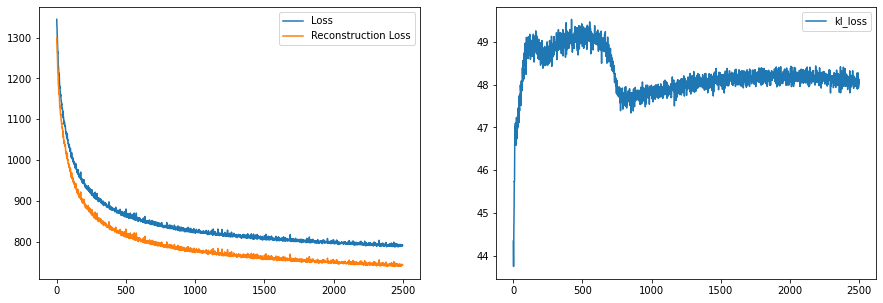

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

#Plot Loss & Reconstruction Loss
plt.subplot(1,2,1)
plt.plot(epoch_range, loss, label="Loss")
plt.plot(epoch_range, r_loss, label="Reconstruction Loss")
plt.legend(loc="upper right")

#Plot kl_loss
plt.subplot(1,2,2)
plt.plot(epoch_range, kl_loss, label="kl_loss")
plt.legend(loc="upper right")


plt.show()

In [25]:
res = encoder.predict(X_st)

In [36]:
res[0].shape

(2550, 64)

In [26]:
res[0][0]

array([-0.00307976, -1.1805284 ,  0.22827527, -0.15053737, -0.11536375,
       -0.477198  , -1.6762651 ,  0.66038746,  0.00627198,  1.8087617 ,
        0.43536913, -0.03924346, -0.63584375, -0.3904642 ,  0.03670456,
       -1.4562166 ], dtype=float32)

In [27]:
res[0][10]

array([-0.03259687,  0.3734404 , -0.09097619, -1.6786492 , -1.467679  ,
        1.0629382 ,  0.0682946 , -0.88308907,  0.00882897,  0.2844992 ,
       -0.7211197 , -0.29576588,  0.00633836,  1.1843214 ,  0.00340893,
       -0.07596928], dtype=float32)

In [28]:
import matplotlib.image as mpimg

In [30]:
res_f = vae.decoder.predict(res[0])

In [19]:
res_f[0][0]

array([[0.2976402 , 0.21214461, 0.12714824],
       [0.28802344, 0.18942228, 0.11618245],
       [0.29740113, 0.19919339, 0.12651873],
       [0.28195307, 0.19971296, 0.1262205 ],
       [0.27050453, 0.18921128, 0.11036536],
       [0.28370017, 0.19511575, 0.11447662],
       [0.2854606 , 0.19721761, 0.12076139],
       [0.28423345, 0.19708622, 0.11080131],
       [0.27664435, 0.19037089, 0.1002233 ],
       [0.29495472, 0.19649512, 0.10530677],
       [0.29424092, 0.19553536, 0.10738522],
       [0.2591611 , 0.17892373, 0.09964892],
       [0.25628787, 0.17769325, 0.09885466],
       [0.2689705 , 0.18205631, 0.10700864],
       [0.25947678, 0.1779997 , 0.10867614],
       [0.2454662 , 0.16669554, 0.09633738],
       [0.25774544, 0.17412749, 0.09714502],
       [0.27502936, 0.1779722 , 0.1023663 ],
       [0.2907496 , 0.18715483, 0.10698819],
       [0.2828325 , 0.18109101, 0.09949636],
       [0.2892114 , 0.17939997, 0.09458482],
       [0.29697546, 0.17995185, 0.09934086],
       [0.

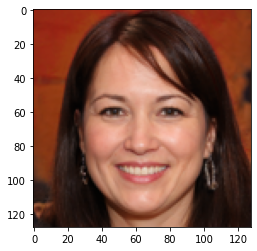

In [33]:
plt.imshow(y[9])

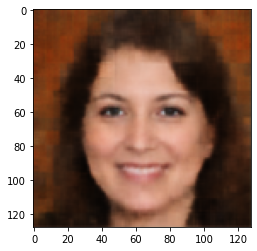

In [34]:
plt.imshow(res_f[9])

# Saving Models

In [15]:
from icangetyoursmile.utils import save_model

## Encoder

In [20]:
save_model(vae.encoder, "Vae_encoder_16")

INFO:tensorflow:Assets written to: ./saved_models/Vae_encoder_16/assets


## Decoder

In [21]:
save_model(vae.decoder, "Vae_decoder_16")

INFO:tensorflow:Assets written to: ./saved_models/Vae_decoder_16/assets


# Loading Models

In [3]:
from icangetyoursmile.utils import loading_model

In [4]:
vae_encoder = loading_model("Vae_encoder_16")

2022-03-10 09:23:24.830395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-10 09:23:24.830568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 09:23:24.830618: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-10 09:23:24.830653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-10 09:23:24.830686: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [5]:
vae_decoder = loading_model("Vae_decoder_16")

In [12]:
res2 = vae_encoder.predict(X_st)

In [42]:
res2_f = vae_decoder.predict(res2[2])

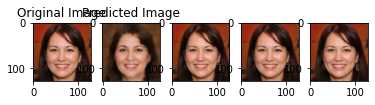

In [85]:
plt.subplot(1,5,1)
plt.imshow(y[9])
plt.title("Original Image")

plt.subplot(1,5,2)
plt.imshow(res2_f[9])
plt.title("Predicted Image")

plt.subplot(1,5,3)
plt.imshow(y[9])

plt.subplot(1,5,4)
plt.imshow(y[9])

plt.subplot(1,5,5)
plt.imshow(y[9])


plt.show()

# Refit Model loaded

In [11]:
vae2 = VAE(vae_encoder_2000,vae_decoder_2000)
vae2.compile(optimizer=keras.optimizers.Adam())

In [13]:
history2 = vae2.fit(X_st, epochs=2000, batch_size=128)

Epoch 1/2000
20/20 [==============================] - 16s 731ms/step - loss: 1670.9007 - reconstruction_loss: 1468.1829 - kl_loss: 53.4820
Epoch 2/2000
20/20 [==============================] - 14s 718ms/step - loss: 1197.7015 - reconstruction_loss: 1102.1106 - kl_loss: 47.4494
Epoch 3/2000
20/20 [==============================] - 14s 711ms/step - loss: 1034.4995 - reconstruction_loss: 960.4553 - kl_loss: 50.5533
Epoch 4/2000
20/20 [==============================] - 14s 720ms/step - loss: 945.3914 - reconstruction_loss: 881.7775 - kl_loss: 55.1998
Epoch 5/2000
20/20 [==============================] - 14s 712ms/step - loss: 909.0101 - reconstruction_loss: 850.1802 - kl_loss: 57.4988
Epoch 6/2000
20/20 [==============================] - 14s 716ms/step - loss: 899.4929 - reconstruction_loss: 840.8133 - kl_loss: 57.4846
Epoch 7/2000
20/20 [==============================] - 15s 723ms/step - loss: 899.9288 - reconstruction_loss: 838.3840 - kl_loss: 57.4743
Epoch 8/2000
20/20 [================

20/20 [==============================] - 16s 800ms/step - loss: 896.3302 - reconstruction_loss: 834.4049 - kl_loss: 58.5250
Epoch 120/2000
20/20 [==============================] - 16s 799ms/step - loss: 883.8279 - reconstruction_loss: 830.9330 - kl_loss: 58.7031
Epoch 121/2000
20/20 [==============================] - 16s 806ms/step - loss: 881.9023 - reconstruction_loss: 825.5706 - kl_loss: 59.0161
Epoch 122/2000
20/20 [==============================] - 16s 787ms/step - loss: 881.2632 - reconstruction_loss: 824.5700 - kl_loss: 58.8961
Epoch 123/2000
20/20 [==============================] - 16s 777ms/step - loss: 882.9673 - reconstruction_loss: 831.7575 - kl_loss: 58.7454
Epoch 124/2000
20/20 [==============================] - 16s 777ms/step - loss: 891.0821 - reconstruction_loss: 837.1237 - kl_loss: 58.4057
Epoch 125/2000
20/20 [==============================] - 15s 765ms/step - loss: 885.3865 - reconstruction_loss: 826.8805 - kl_loss: 58.5335
Epoch 126/2000
20/20 [====================

20/20 [==============================] - 15s 765ms/step - loss: 883.3852 - reconstruction_loss: 829.3823 - kl_loss: 58.5158
Epoch 179/2000
20/20 [==============================] - 17s 830ms/step - loss: 879.7999 - reconstruction_loss: 822.8752 - kl_loss: 58.7384
Epoch 180/2000
20/20 [==============================] - 16s 785ms/step - loss: 885.6611 - reconstruction_loss: 824.1846 - kl_loss: 58.3930
Epoch 181/2000
20/20 [==============================] - 15s 761ms/step - loss: 874.9171 - reconstruction_loss: 819.6794 - kl_loss: 58.6656
Epoch 182/2000
20/20 [==============================] - 15s 768ms/step - loss: 879.2782 - reconstruction_loss: 820.4777 - kl_loss: 58.3968
Epoch 183/2000
20/20 [==============================] - 15s 774ms/step - loss: 875.5685 - reconstruction_loss: 823.0782 - kl_loss: 58.3501
Epoch 184/2000
20/20 [==============================] - 15s 753ms/step - loss: 877.1904 - reconstruction_loss: 817.5026 - kl_loss: 58.3949
Epoch 185/2000
20/20 [====================

20/20 [==============================] - 15s 761ms/step - loss: 879.0960 - reconstruction_loss: 818.7628 - kl_loss: 58.3325
Epoch 238/2000
20/20 [==============================] - 15s 763ms/step - loss: 875.6368 - reconstruction_loss: 818.6354 - kl_loss: 58.6224
Epoch 239/2000
20/20 [==============================] - 16s 788ms/step - loss: 880.7600 - reconstruction_loss: 824.4478 - kl_loss: 57.8520
Epoch 240/2000
20/20 [==============================] - 15s 740ms/step - loss: 881.3906 - reconstruction_loss: 822.4348 - kl_loss: 58.4589
Epoch 241/2000
20/20 [==============================] - 15s 761ms/step - loss: 873.9493 - reconstruction_loss: 818.2058 - kl_loss: 58.6595
Epoch 242/2000
20/20 [==============================] - 15s 758ms/step - loss: 868.2989 - reconstruction_loss: 815.4496 - kl_loss: 58.6507
Epoch 243/2000
20/20 [==============================] - 15s 760ms/step - loss: 871.6263 - reconstruction_loss: 815.2645 - kl_loss: 58.6266
Epoch 244/2000
20/20 [====================

20/20 [==============================] - 16s 789ms/step - loss: 880.3398 - reconstruction_loss: 821.4404 - kl_loss: 58.0384
Epoch 297/2000
20/20 [==============================] - 16s 787ms/step - loss: 870.4101 - reconstruction_loss: 816.3692 - kl_loss: 58.3332
Epoch 298/2000
20/20 [==============================] - 16s 786ms/step - loss: 871.4665 - reconstruction_loss: 814.0800 - kl_loss: 58.1884
Epoch 299/2000
20/20 [==============================] - 16s 802ms/step - loss: 864.7509 - reconstruction_loss: 815.4423 - kl_loss: 58.2649
Epoch 300/2000
20/20 [==============================] - 16s 774ms/step - loss: 886.5686 - reconstruction_loss: 824.4363 - kl_loss: 58.0072
Epoch 301/2000
20/20 [==============================] - 15s 754ms/step - loss: 873.8010 - reconstruction_loss: 817.0735 - kl_loss: 58.2234
Epoch 302/2000
20/20 [==============================] - 15s 767ms/step - loss: 870.0675 - reconstruction_loss: 814.3051 - kl_loss: 58.0078
Epoch 303/2000
20/20 [====================

20/20 [==============================] - 16s 824ms/step - loss: 867.3323 - reconstruction_loss: 808.7916 - kl_loss: 57.9094
Epoch 356/2000
20/20 [==============================] - 17s 867ms/step - loss: 862.7098 - reconstruction_loss: 809.1663 - kl_loss: 57.9235
Epoch 357/2000
20/20 [==============================] - 16s 811ms/step - loss: 866.7600 - reconstruction_loss: 811.1940 - kl_loss: 57.8364
Epoch 358/2000
20/20 [==============================] - 16s 799ms/step - loss: 868.9398 - reconstruction_loss: 812.4435 - kl_loss: 57.7740
Epoch 359/2000
20/20 [==============================] - 17s 843ms/step - loss: 861.5549 - reconstruction_loss: 808.0342 - kl_loss: 57.8061
Epoch 360/2000
20/20 [==============================] - 16s 822ms/step - loss: 868.1965 - reconstruction_loss: 813.3000 - kl_loss: 57.9750
Epoch 361/2000
20/20 [==============================] - 17s 832ms/step - loss: 869.3049 - reconstruction_loss: 810.2791 - kl_loss: 57.9451
Epoch 362/2000
20/20 [====================

20/20 [==============================] - 16s 784ms/step - loss: 870.6324 - reconstruction_loss: 808.2346 - kl_loss: 57.8665
Epoch 415/2000
20/20 [==============================] - 16s 787ms/step - loss: 862.1145 - reconstruction_loss: 806.6173 - kl_loss: 57.5951
Epoch 416/2000
20/20 [==============================] - 16s 790ms/step - loss: 871.7726 - reconstruction_loss: 814.3287 - kl_loss: 57.7084
Epoch 417/2000
20/20 [==============================] - 16s 794ms/step - loss: 880.1187 - reconstruction_loss: 823.7256 - kl_loss: 57.2597
Epoch 418/2000
20/20 [==============================] - 16s 777ms/step - loss: 869.0981 - reconstruction_loss: 811.8231 - kl_loss: 57.4607
Epoch 419/2000
20/20 [==============================] - 15s 772ms/step - loss: 866.5998 - reconstruction_loss: 809.7793 - kl_loss: 57.8290
Epoch 420/2000
20/20 [==============================] - 15s 772ms/step - loss: 865.8648 - reconstruction_loss: 808.1649 - kl_loss: 57.6299
Epoch 421/2000
20/20 [====================

20/20 [==============================] - 15s 766ms/step - loss: 871.0013 - reconstruction_loss: 816.1180 - kl_loss: 57.5270
Epoch 474/2000
20/20 [==============================] - 15s 768ms/step - loss: 868.7108 - reconstruction_loss: 811.1272 - kl_loss: 57.5255
Epoch 475/2000
20/20 [==============================] - 15s 755ms/step - loss: 872.3318 - reconstruction_loss: 815.2607 - kl_loss: 57.4309
Epoch 476/2000
20/20 [==============================] - 16s 774ms/step - loss: 867.9747 - reconstruction_loss: 808.5137 - kl_loss: 57.3934
Epoch 477/2000
20/20 [==============================] - 15s 759ms/step - loss: 864.4779 - reconstruction_loss: 811.4744 - kl_loss: 57.5384
Epoch 478/2000
20/20 [==============================] - 15s 764ms/step - loss: 864.0858 - reconstruction_loss: 807.6133 - kl_loss: 57.5202
Epoch 479/2000
20/20 [==============================] - 15s 756ms/step - loss: 859.6552 - reconstruction_loss: 807.8273 - kl_loss: 57.6142
Epoch 480/2000
20/20 [====================

20/20 [==============================] - 15s 773ms/step - loss: 861.0031 - reconstruction_loss: 807.7430 - kl_loss: 57.6939
Epoch 533/2000
20/20 [==============================] - 16s 787ms/step - loss: 861.9437 - reconstruction_loss: 805.6187 - kl_loss: 57.3462
Epoch 534/2000
20/20 [==============================] - 16s 799ms/step - loss: 856.2506 - reconstruction_loss: 805.7222 - kl_loss: 57.6153
Epoch 535/2000
20/20 [==============================] - 15s 761ms/step - loss: 858.1554 - reconstruction_loss: 805.9867 - kl_loss: 57.5114
Epoch 536/2000
20/20 [==============================] - 15s 766ms/step - loss: 862.3852 - reconstruction_loss: 804.8612 - kl_loss: 57.4058
Epoch 537/2000
20/20 [==============================] - 15s 756ms/step - loss: 862.4685 - reconstruction_loss: 802.3852 - kl_loss: 57.8334
Epoch 538/2000
20/20 [==============================] - 15s 761ms/step - loss: 861.8937 - reconstruction_loss: 803.9203 - kl_loss: 57.5012
Epoch 539/2000
20/20 [====================

20/20 [==============================] - 15s 761ms/step - loss: 864.7959 - reconstruction_loss: 805.1219 - kl_loss: 57.7211
Epoch 592/2000
20/20 [==============================] - 15s 767ms/step - loss: 859.8702 - reconstruction_loss: 803.8785 - kl_loss: 57.6732
Epoch 593/2000
20/20 [==============================] - 15s 764ms/step - loss: 861.7727 - reconstruction_loss: 804.8092 - kl_loss: 57.6329
Epoch 594/2000
20/20 [==============================] - 16s 779ms/step - loss: 856.5637 - reconstruction_loss: 804.8470 - kl_loss: 57.6850
Epoch 595/2000
20/20 [==============================] - 15s 765ms/step - loss: 864.7237 - reconstruction_loss: 806.8448 - kl_loss: 57.4498
Epoch 596/2000
20/20 [==============================] - 16s 775ms/step - loss: 857.9307 - reconstruction_loss: 802.1698 - kl_loss: 57.7319
Epoch 597/2000
20/20 [==============================] - 15s 747ms/step - loss: 865.1840 - reconstruction_loss: 803.4883 - kl_loss: 57.5824
Epoch 598/2000
20/20 [====================

20/20 [==============================] - 16s 790ms/step - loss: 862.1569 - reconstruction_loss: 807.3643 - kl_loss: 57.5341
Epoch 651/2000
20/20 [==============================] - 16s 785ms/step - loss: 860.0995 - reconstruction_loss: 802.7417 - kl_loss: 57.5626
Epoch 652/2000
20/20 [==============================] - 15s 772ms/step - loss: 856.7127 - reconstruction_loss: 799.5350 - kl_loss: 57.8913
Epoch 653/2000
20/20 [==============================] - 15s 752ms/step - loss: 865.5595 - reconstruction_loss: 804.6879 - kl_loss: 57.6475
Epoch 654/2000
20/20 [==============================] - 15s 768ms/step - loss: 857.9026 - reconstruction_loss: 803.5475 - kl_loss: 57.5546
Epoch 655/2000
20/20 [==============================] - 15s 749ms/step - loss: 870.7660 - reconstruction_loss: 808.4961 - kl_loss: 57.5663
Epoch 656/2000
20/20 [==============================] - 15s 743ms/step - loss: 860.1966 - reconstruction_loss: 803.5386 - kl_loss: 57.9282
Epoch 657/2000
20/20 [====================

20/20 [==============================] - 15s 764ms/step - loss: 867.3142 - reconstruction_loss: 813.4974 - kl_loss: 57.2840
Epoch 710/2000
20/20 [==============================] - 16s 776ms/step - loss: 869.2354 - reconstruction_loss: 814.2795 - kl_loss: 57.4143
Epoch 711/2000
20/20 [==============================] - 15s 746ms/step - loss: 862.0431 - reconstruction_loss: 806.4144 - kl_loss: 57.4129
Epoch 712/2000
20/20 [==============================] - 15s 746ms/step - loss: 874.7726 - reconstruction_loss: 813.3228 - kl_loss: 57.4219
Epoch 713/2000
20/20 [==============================] - 15s 768ms/step - loss: 860.9313 - reconstruction_loss: 804.6110 - kl_loss: 57.5541
Epoch 714/2000
20/20 [==============================] - 15s 751ms/step - loss: 858.8929 - reconstruction_loss: 806.7581 - kl_loss: 57.8466
Epoch 715/2000
20/20 [==============================] - 15s 760ms/step - loss: 853.8616 - reconstruction_loss: 801.4229 - kl_loss: 57.3541
Epoch 716/2000
20/20 [====================

20/20 [==============================] - 16s 777ms/step - loss: 862.2282 - reconstruction_loss: 808.4366 - kl_loss: 57.4637
Epoch 769/2000
20/20 [==============================] - 16s 787ms/step - loss: 863.1403 - reconstruction_loss: 803.2753 - kl_loss: 57.3212
Epoch 770/2000
20/20 [==============================] - 15s 769ms/step - loss: 866.7659 - reconstruction_loss: 804.1397 - kl_loss: 57.4288
Epoch 771/2000
20/20 [==============================] - 15s 762ms/step - loss: 857.7978 - reconstruction_loss: 801.6085 - kl_loss: 57.5106
Epoch 772/2000
20/20 [==============================] - 15s 768ms/step - loss: 857.1065 - reconstruction_loss: 800.2562 - kl_loss: 57.5602
Epoch 773/2000
20/20 [==============================] - 15s 763ms/step - loss: 856.6854 - reconstruction_loss: 803.9354 - kl_loss: 57.6089
Epoch 774/2000
20/20 [==============================] - 15s 755ms/step - loss: 854.9769 - reconstruction_loss: 803.0884 - kl_loss: 57.7125
Epoch 775/2000
20/20 [====================

20/20 [==============================] - 16s 803ms/step - loss: 853.6400 - reconstruction_loss: 795.2181 - kl_loss: 57.5618
Epoch 828/2000
20/20 [==============================] - 16s 809ms/step - loss: 855.0592 - reconstruction_loss: 799.3501 - kl_loss: 57.4725
Epoch 829/2000
20/20 [==============================] - 15s 752ms/step - loss: 861.7840 - reconstruction_loss: 807.3948 - kl_loss: 57.5406
Epoch 830/2000
20/20 [==============================] - 15s 752ms/step - loss: 865.5586 - reconstruction_loss: 806.1217 - kl_loss: 57.2320
Epoch 831/2000
20/20 [==============================] - 15s 767ms/step - loss: 856.9665 - reconstruction_loss: 803.7534 - kl_loss: 57.6173
Epoch 832/2000
20/20 [==============================] - 15s 772ms/step - loss: 859.9819 - reconstruction_loss: 805.6245 - kl_loss: 57.4261
Epoch 833/2000
20/20 [==============================] - 15s 751ms/step - loss: 861.4061 - reconstruction_loss: 800.8247 - kl_loss: 57.2978
Epoch 834/2000
20/20 [====================

20/20 [==============================] - 15s 767ms/step - loss: 850.1563 - reconstruction_loss: 797.4896 - kl_loss: 57.5162
Epoch 887/2000
20/20 [==============================] - 15s 764ms/step - loss: 862.5021 - reconstruction_loss: 803.2318 - kl_loss: 57.4344
Epoch 888/2000
20/20 [==============================] - 16s 775ms/step - loss: 856.1199 - reconstruction_loss: 798.1815 - kl_loss: 57.6700
Epoch 889/2000
20/20 [==============================] - 15s 744ms/step - loss: 855.0258 - reconstruction_loss: 796.2416 - kl_loss: 57.5552
Epoch 890/2000
20/20 [==============================] - 15s 774ms/step - loss: 853.9985 - reconstruction_loss: 801.0208 - kl_loss: 57.4555
Epoch 891/2000
20/20 [==============================] - 15s 764ms/step - loss: 851.9149 - reconstruction_loss: 797.2371 - kl_loss: 57.4890
Epoch 892/2000
20/20 [==============================] - 15s 766ms/step - loss: 859.3892 - reconstruction_loss: 798.3481 - kl_loss: 57.5454
Epoch 893/2000
20/20 [====================

20/20 [==============================] - 15s 740ms/step - loss: 854.7210 - reconstruction_loss: 794.8300 - kl_loss: 57.5905
Epoch 946/2000
20/20 [==============================] - 15s 759ms/step - loss: 847.2050 - reconstruction_loss: 793.7841 - kl_loss: 57.4926
Epoch 947/2000
20/20 [==============================] - 15s 763ms/step - loss: 857.1913 - reconstruction_loss: 803.7068 - kl_loss: 57.3672
Epoch 948/2000
20/20 [==============================] - 15s 772ms/step - loss: 866.9241 - reconstruction_loss: 812.9053 - kl_loss: 57.1938
Epoch 949/2000
20/20 [==============================] - 15s 752ms/step - loss: 861.7494 - reconstruction_loss: 805.9889 - kl_loss: 57.7355
Epoch 950/2000
20/20 [==============================] - 15s 769ms/step - loss: 856.3722 - reconstruction_loss: 803.5057 - kl_loss: 57.4392
Epoch 951/2000
20/20 [==============================] - 15s 753ms/step - loss: 863.5150 - reconstruction_loss: 804.5128 - kl_loss: 57.4223
Epoch 952/2000
20/20 [====================

20/20 [==============================] - 15s 753ms/step - loss: 851.0685 - reconstruction_loss: 796.1213 - kl_loss: 57.6379
Epoch 1005/2000
20/20 [==============================] - 16s 788ms/step - loss: 857.1466 - reconstruction_loss: 795.6813 - kl_loss: 57.3255
Epoch 1006/2000
20/20 [==============================] - 16s 783ms/step - loss: 850.4265 - reconstruction_loss: 793.9908 - kl_loss: 57.5817
Epoch 1007/2000
20/20 [==============================] - 15s 772ms/step - loss: 851.4928 - reconstruction_loss: 791.8477 - kl_loss: 57.5829
Epoch 1008/2000
20/20 [==============================] - 15s 766ms/step - loss: 848.3877 - reconstruction_loss: 790.5492 - kl_loss: 57.4238
Epoch 1009/2000
20/20 [==============================] - 15s 739ms/step - loss: 850.9997 - reconstruction_loss: 795.3073 - kl_loss: 57.6631
Epoch 1010/2000
20/20 [==============================] - 15s 770ms/step - loss: 863.8732 - reconstruction_loss: 809.3143 - kl_loss: 57.0868
Epoch 1011/2000
20/20 [=============

20/20 [==============================] - 15s 759ms/step - loss: 848.0216 - reconstruction_loss: 789.8101 - kl_loss: 57.5054
Epoch 1121/2000
20/20 [==============================] - 15s 758ms/step - loss: 844.7437 - reconstruction_loss: 794.1956 - kl_loss: 57.5442
Epoch 1122/2000
20/20 [==============================] - 15s 772ms/step - loss: 847.2273 - reconstruction_loss: 792.8187 - kl_loss: 57.4601
Epoch 1123/2000
20/20 [==============================] - 15s 757ms/step - loss: 851.5969 - reconstruction_loss: 801.7434 - kl_loss: 57.1520
Epoch 1124/2000
20/20 [==============================] - 15s 753ms/step - loss: 854.4335 - reconstruction_loss: 796.7011 - kl_loss: 57.3876
Epoch 1125/2000
20/20 [==============================] - 15s 763ms/step - loss: 852.5535 - reconstruction_loss: 795.0158 - kl_loss: 57.4990
Epoch 1126/2000
20/20 [==============================] - 15s 756ms/step - loss: 849.9971 - reconstruction_loss: 793.7849 - kl_loss: 57.7693
Epoch 1127/2000
20/20 [=============

20/20 [==============================] - 15s 763ms/step - loss: 848.6668 - reconstruction_loss: 795.7535 - kl_loss: 57.3081
Epoch 1237/2000
20/20 [==============================] - 15s 763ms/step - loss: 852.6578 - reconstruction_loss: 803.7614 - kl_loss: 57.3699
Epoch 1238/2000
20/20 [==============================] - 15s 768ms/step - loss: 864.0914 - reconstruction_loss: 800.9324 - kl_loss: 57.2062
Epoch 1239/2000
20/20 [==============================] - 15s 762ms/step - loss: 849.4990 - reconstruction_loss: 792.0688 - kl_loss: 57.5823
Epoch 1240/2000
20/20 [==============================] - 15s 754ms/step - loss: 852.6870 - reconstruction_loss: 791.2177 - kl_loss: 57.5933
Epoch 1241/2000
20/20 [==============================] - 15s 770ms/step - loss: 845.4162 - reconstruction_loss: 791.8467 - kl_loss: 57.3455
Epoch 1242/2000
20/20 [==============================] - 15s 753ms/step - loss: 844.4936 - reconstruction_loss: 791.8676 - kl_loss: 57.3310
Epoch 1243/2000
20/20 [=============

20/20 [==============================] - 15s 760ms/step - loss: 840.5491 - reconstruction_loss: 787.7965 - kl_loss: 57.4100
Epoch 1353/2000
20/20 [==============================] - 15s 771ms/step - loss: 841.4243 - reconstruction_loss: 786.1821 - kl_loss: 57.4186
Epoch 1354/2000
20/20 [==============================] - 15s 758ms/step - loss: 845.9480 - reconstruction_loss: 787.4499 - kl_loss: 57.3010
Epoch 1355/2000
20/20 [==============================] - 15s 759ms/step - loss: 845.6462 - reconstruction_loss: 787.5696 - kl_loss: 57.4476
Epoch 1356/2000
20/20 [==============================] - 15s 750ms/step - loss: 843.8652 - reconstruction_loss: 787.0051 - kl_loss: 57.4000
Epoch 1357/2000
20/20 [==============================] - 15s 766ms/step - loss: 844.3225 - reconstruction_loss: 790.4534 - kl_loss: 57.2790
Epoch 1358/2000
20/20 [==============================] - 15s 752ms/step - loss: 850.8873 - reconstruction_loss: 796.3723 - kl_loss: 57.0474
Epoch 1359/2000
20/20 [=============

20/20 [==============================] - 15s 747ms/step - loss: 845.3837 - reconstruction_loss: 789.5818 - kl_loss: 57.2413
Epoch 1469/2000
20/20 [==============================] - 15s 756ms/step - loss: 847.2843 - reconstruction_loss: 790.5281 - kl_loss: 57.0348
Epoch 1470/2000
20/20 [==============================] - 15s 746ms/step - loss: 849.1277 - reconstruction_loss: 792.9979 - kl_loss: 57.1244
Epoch 1471/2000
20/20 [==============================] - 15s 762ms/step - loss: 843.9194 - reconstruction_loss: 788.9313 - kl_loss: 57.1441
Epoch 1472/2000
20/20 [==============================] - 15s 747ms/step - loss: 843.8673 - reconstruction_loss: 788.5417 - kl_loss: 57.0792
Epoch 1473/2000
20/20 [==============================] - 15s 769ms/step - loss: 847.0388 - reconstruction_loss: 787.8545 - kl_loss: 57.2765
Epoch 1474/2000
20/20 [==============================] - 15s 736ms/step - loss: 840.7719 - reconstruction_loss: 788.7205 - kl_loss: 57.1906
Epoch 1475/2000
20/20 [=============

20/20 [==============================] - 15s 763ms/step - loss: 844.7849 - reconstruction_loss: 790.8038 - kl_loss: 56.9348
Epoch 1585/2000
20/20 [==============================] - 15s 754ms/step - loss: 844.5459 - reconstruction_loss: 785.5057 - kl_loss: 57.0630
Epoch 1586/2000
20/20 [==============================] - 15s 749ms/step - loss: 851.0369 - reconstruction_loss: 796.3108 - kl_loss: 56.7319
Epoch 1587/2000
20/20 [==============================] - 15s 754ms/step - loss: 844.7886 - reconstruction_loss: 786.2488 - kl_loss: 57.1254
Epoch 1588/2000
20/20 [==============================] - 15s 764ms/step - loss: 845.2691 - reconstruction_loss: 785.8411 - kl_loss: 56.9796
Epoch 1589/2000
20/20 [==============================] - 15s 757ms/step - loss: 836.6853 - reconstruction_loss: 788.6141 - kl_loss: 56.9416
Epoch 1590/2000
20/20 [==============================] - 15s 763ms/step - loss: 843.0108 - reconstruction_loss: 784.1871 - kl_loss: 57.0622
Epoch 1591/2000
20/20 [=============

20/20 [==============================] - 15s 768ms/step - loss: 844.1524 - reconstruction_loss: 791.5646 - kl_loss: 56.8731
Epoch 1701/2000
20/20 [==============================] - 15s 743ms/step - loss: 856.6858 - reconstruction_loss: 804.8900 - kl_loss: 56.3541
Epoch 1702/2000
20/20 [==============================] - 15s 768ms/step - loss: 850.2897 - reconstruction_loss: 796.0725 - kl_loss: 56.7124
Epoch 1703/2000
20/20 [==============================] - 15s 752ms/step - loss: 856.1313 - reconstruction_loss: 795.4779 - kl_loss: 56.7850
Epoch 1704/2000
20/20 [==============================] - 15s 770ms/step - loss: 841.1070 - reconstruction_loss: 784.8732 - kl_loss: 56.6988
Epoch 1705/2000
20/20 [==============================] - 15s 755ms/step - loss: 841.9962 - reconstruction_loss: 786.8390 - kl_loss: 57.1294
Epoch 1706/2000
20/20 [==============================] - 15s 763ms/step - loss: 838.5301 - reconstruction_loss: 782.7111 - kl_loss: 56.7307
Epoch 1707/2000
20/20 [=============

20/20 [==============================] - 15s 765ms/step - loss: 837.5733 - reconstruction_loss: 785.1309 - kl_loss: 56.4318
Epoch 1817/2000
20/20 [==============================] - 15s 754ms/step - loss: 843.7091 - reconstruction_loss: 788.4803 - kl_loss: 56.1672
Epoch 1818/2000
20/20 [==============================] - 15s 764ms/step - loss: 842.8112 - reconstruction_loss: 785.6141 - kl_loss: 56.4077
Epoch 1819/2000
20/20 [==============================] - 15s 752ms/step - loss: 845.2360 - reconstruction_loss: 783.0195 - kl_loss: 56.5572
Epoch 1820/2000
20/20 [==============================] - 15s 773ms/step - loss: 837.3890 - reconstruction_loss: 781.2756 - kl_loss: 56.2331
Epoch 1821/2000
20/20 [==============================] - 15s 755ms/step - loss: 837.1799 - reconstruction_loss: 784.5435 - kl_loss: 56.2696
Epoch 1822/2000
20/20 [==============================] - 15s 769ms/step - loss: 839.9393 - reconstruction_loss: 782.4380 - kl_loss: 56.1764
Epoch 1823/2000
20/20 [=============

20/20 [==============================] - 15s 763ms/step - loss: 837.2068 - reconstruction_loss: 784.3085 - kl_loss: 55.5608
Epoch 1933/2000
20/20 [==============================] - 15s 759ms/step - loss: 834.8504 - reconstruction_loss: 781.5980 - kl_loss: 55.7168
Epoch 1934/2000
20/20 [==============================] - 15s 763ms/step - loss: 835.3978 - reconstruction_loss: 783.1125 - kl_loss: 55.5809
Epoch 1935/2000
20/20 [==============================] - 15s 756ms/step - loss: 833.4094 - reconstruction_loss: 780.8567 - kl_loss: 55.5814
Epoch 1936/2000
20/20 [==============================] - 15s 770ms/step - loss: 838.0871 - reconstruction_loss: 784.7792 - kl_loss: 55.7989
Epoch 1937/2000
20/20 [==============================] - 15s 765ms/step - loss: 836.2377 - reconstruction_loss: 782.1945 - kl_loss: 55.5408
Epoch 1938/2000
20/20 [==============================] - 15s 769ms/step - loss: 835.8275 - reconstruction_loss: 784.4494 - kl_loss: 55.7723
Epoch 1939/2000
20/20 [=============

In [14]:
save_model(vae2.encoder, "Vae_encoder_4000")

NameError: name 'vae' is not defined

In [ ]:
save_model(vae2.decoder, "Vae_decoder_4000")

# Demo Day

## Visage Moyen

In [8]:
X_z = np.zeros((1,16))

In [122]:
X_z[0,2]=0
X_z

array([[ 0.5 ,  0.25,  0.  ,  0.5 , -1.5 , -0.25, -0.5 , -0.1 , -0.1 ,
         2.  ,  0.15,  0.23,  0.36, -0.15, -0.15, -0.1 ]])

In [123]:
v_moyen = vae_decoder.predict(X_z).squeeze()

(-0.5, 127.5, 127.5, -0.5)

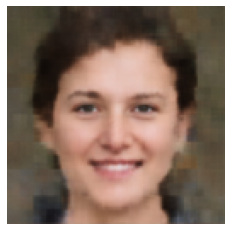

In [125]:
plt.imshow(v_moyen)
plt.axis('off')

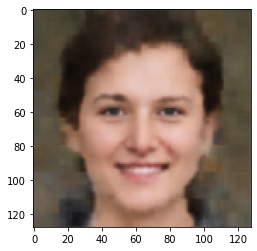

In [128]:
image = plt.imshow(v_moyen)

In [134]:
plt.savefig(image)

AttributeError: 'AxesImage' object has no attribute 'write'

<Figure size 432x288 with 0 Axes>

In [66]:
plt.savefig('visage_moyen')

<Figure size 432x288 with 0 Axes>

## Carte d'identité Visage

In [16]:
def id_card(parameter, vae_model):
    
    X_z = np.zeros((1,16))
    
    numbers = [-2, -0.5, 0, 0.5, 2]
    plt.figure(figsize=(40,60))
    
    for idx, number in enumerate(numbers):
        X_z[0, parameter]= number
        visage = vae_model.predict(X_z).squeeze()
        
        plt.subplot(1,5,idx+1)
        plt.imshow(visage)
        plt.title(f'{numbers[idx]}')
        plt.axis('off')

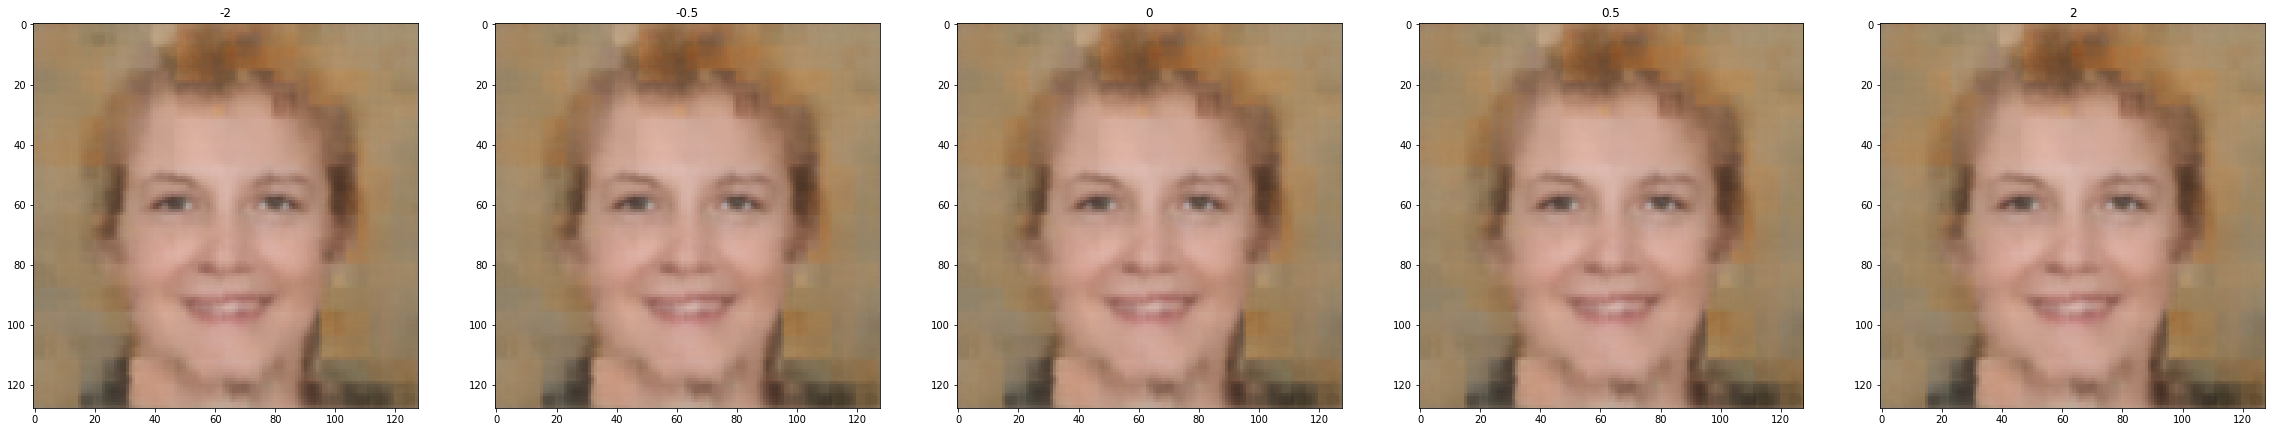

In [45]:
id_card(0, decoder)

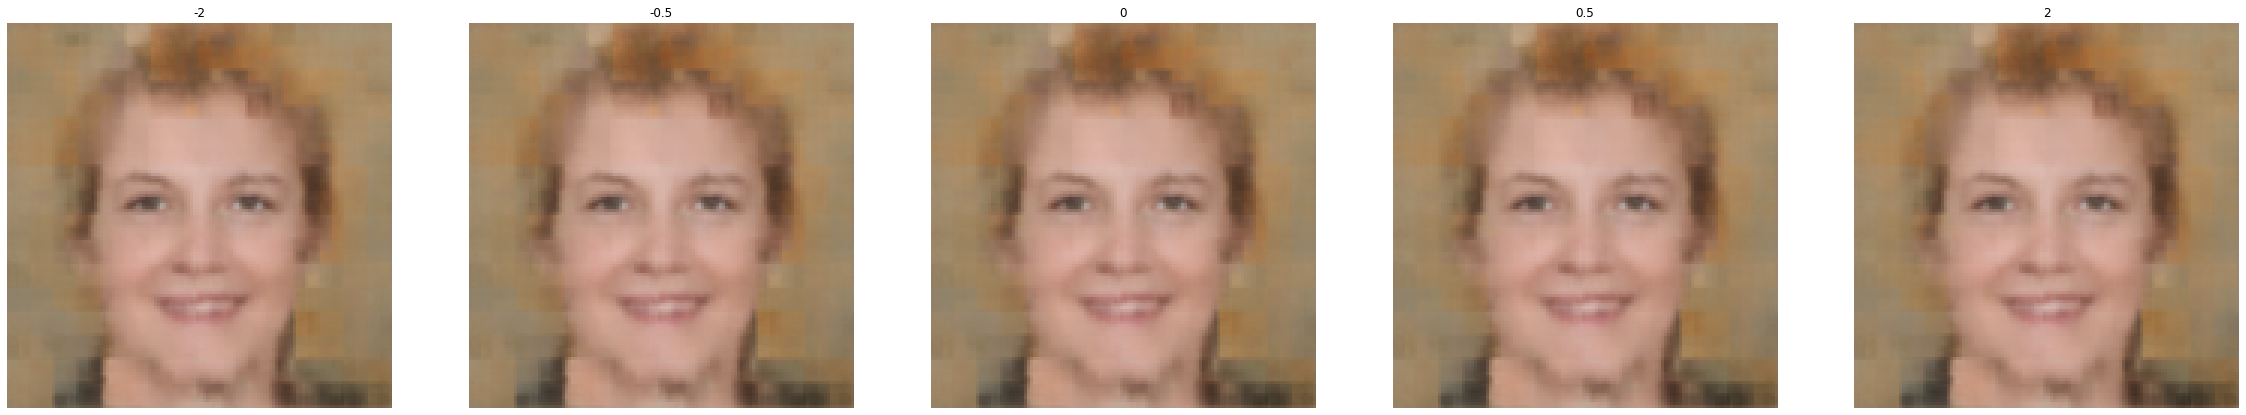

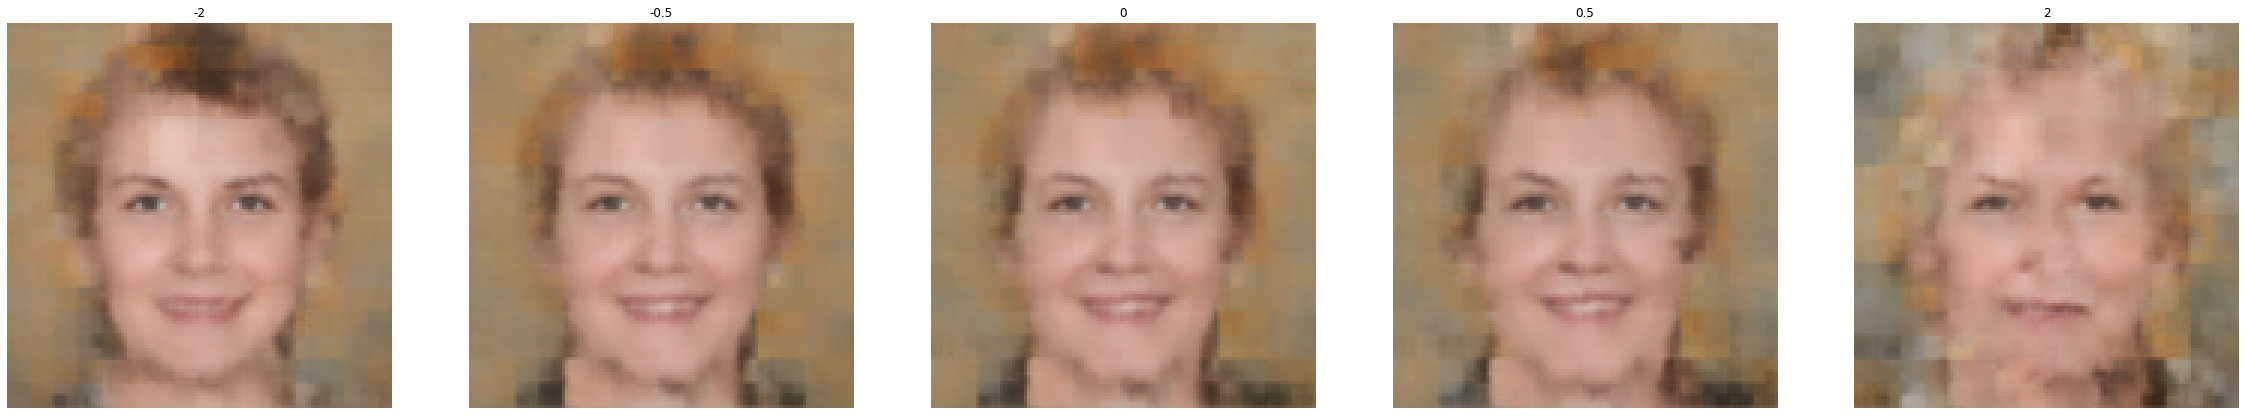

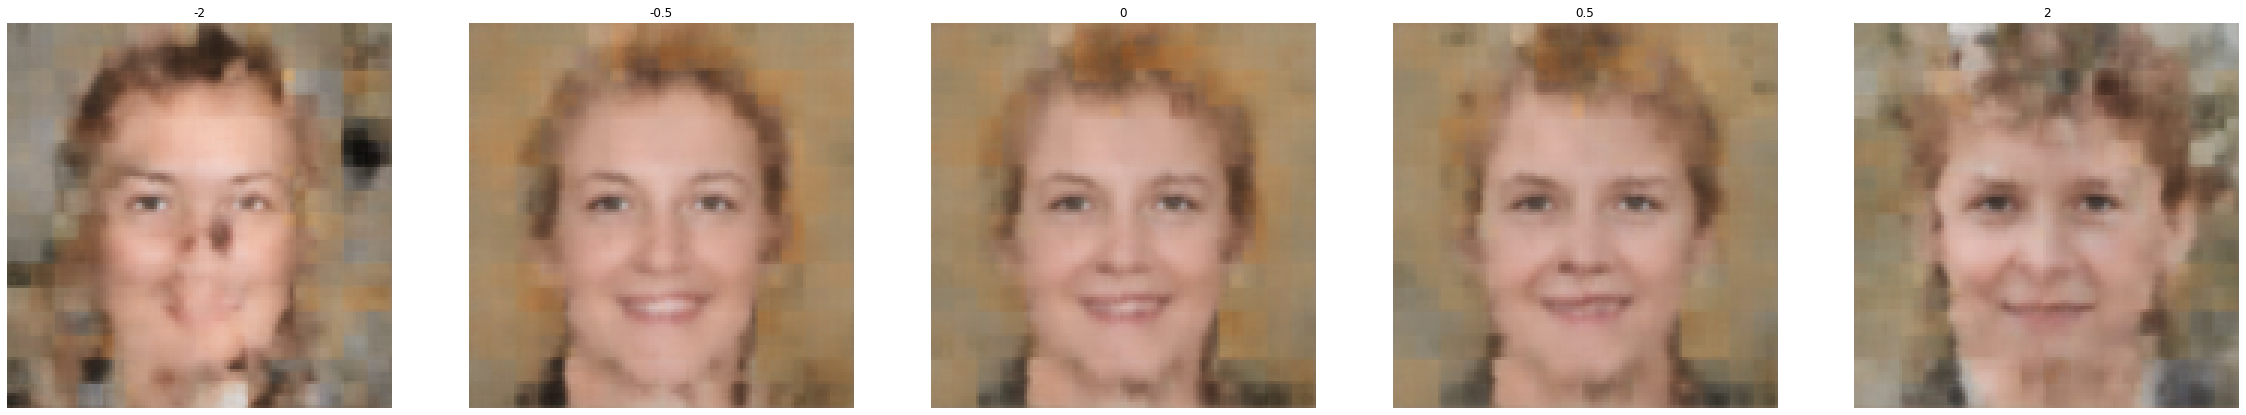

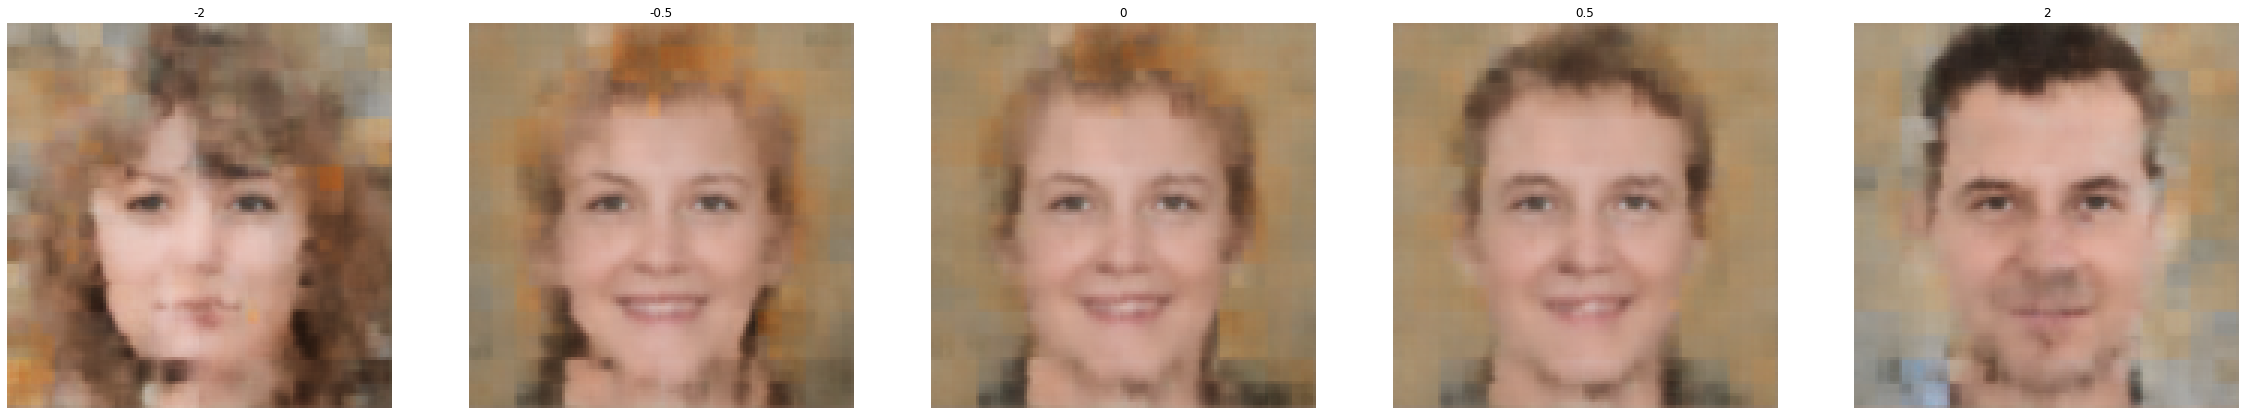

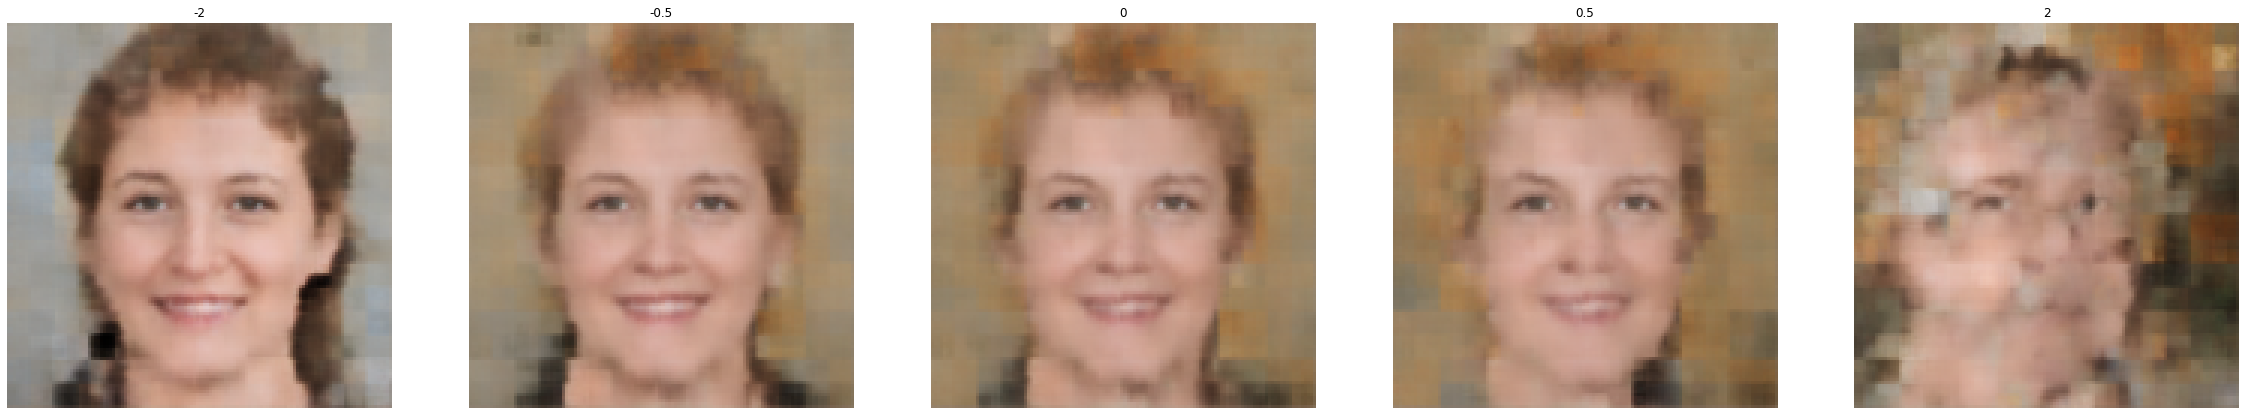

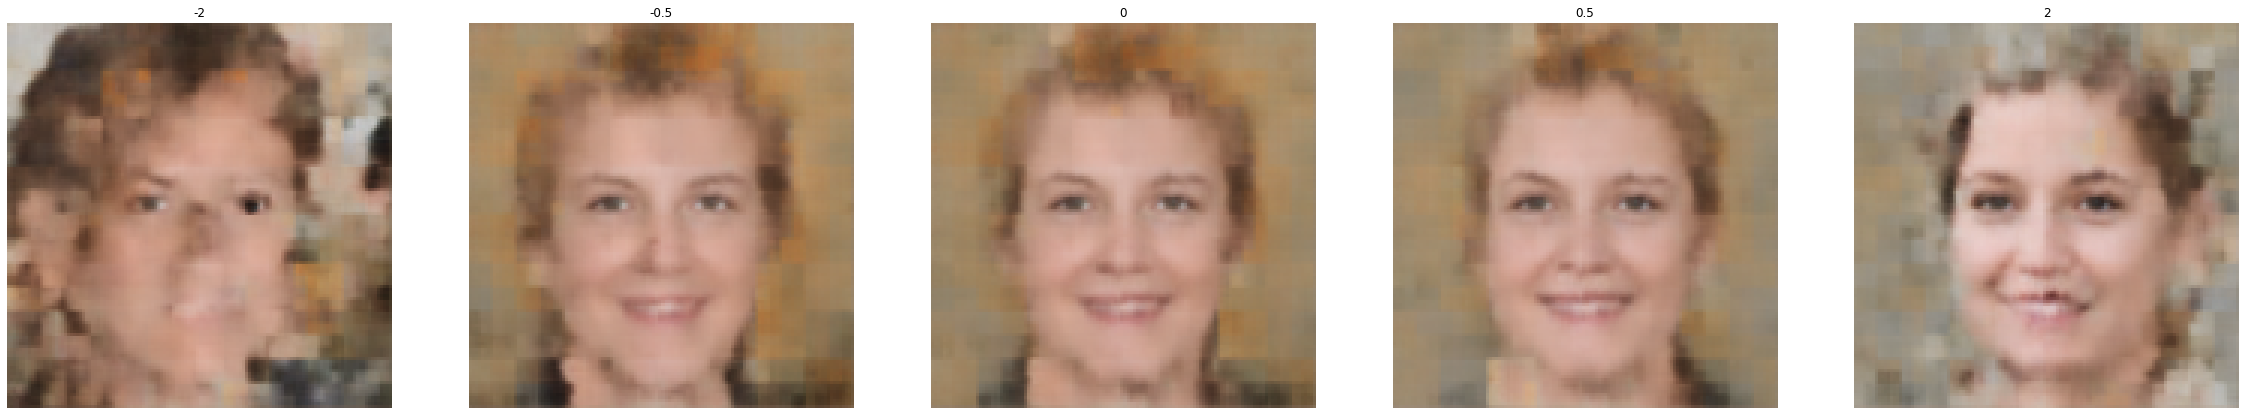

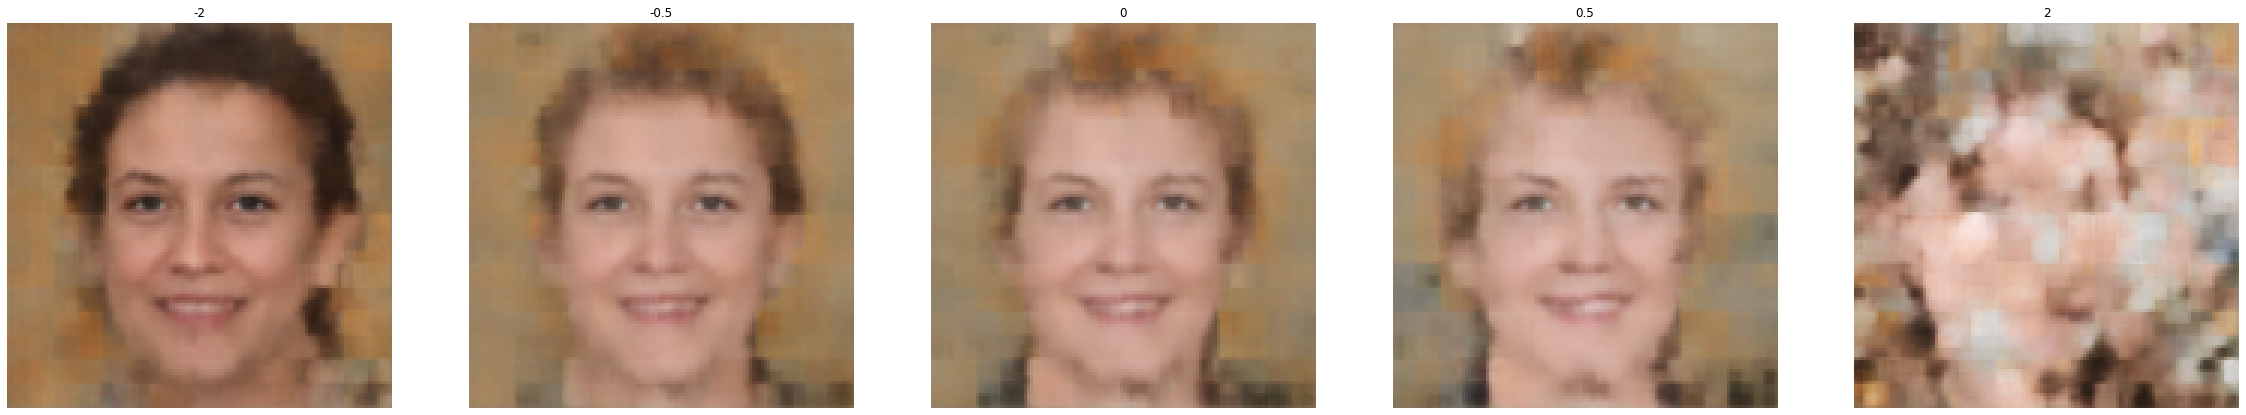

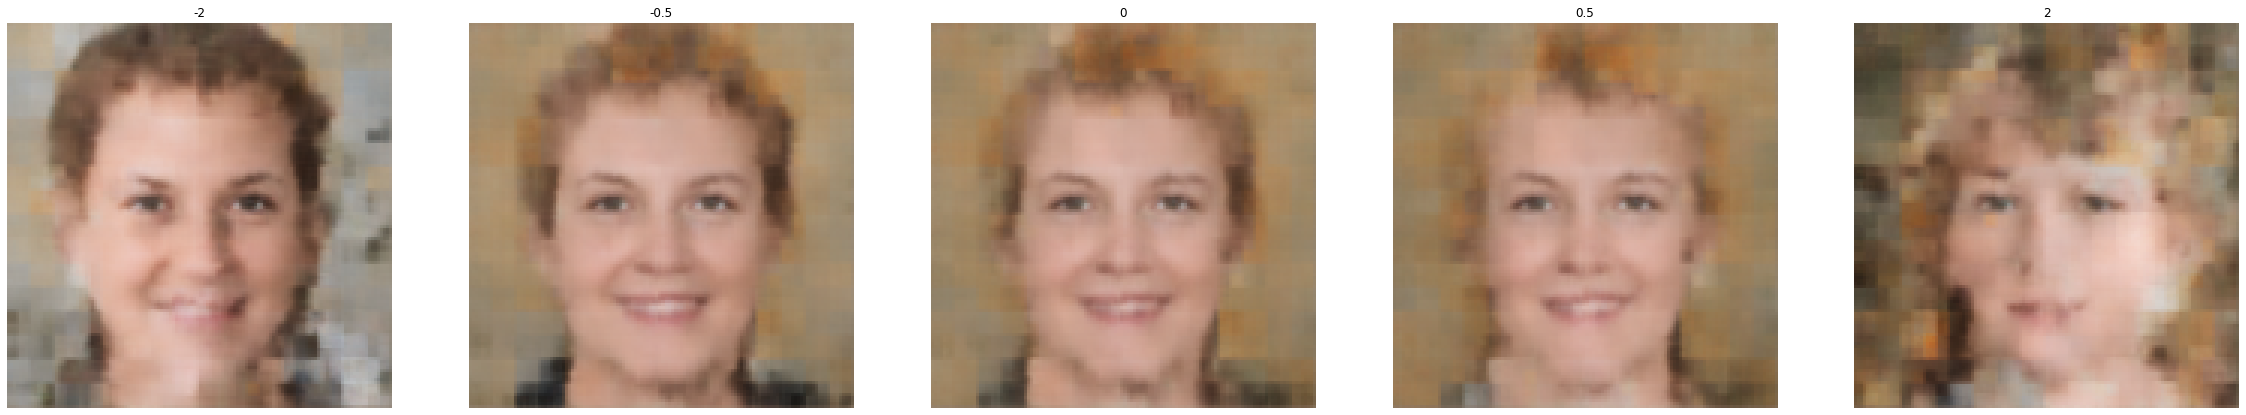

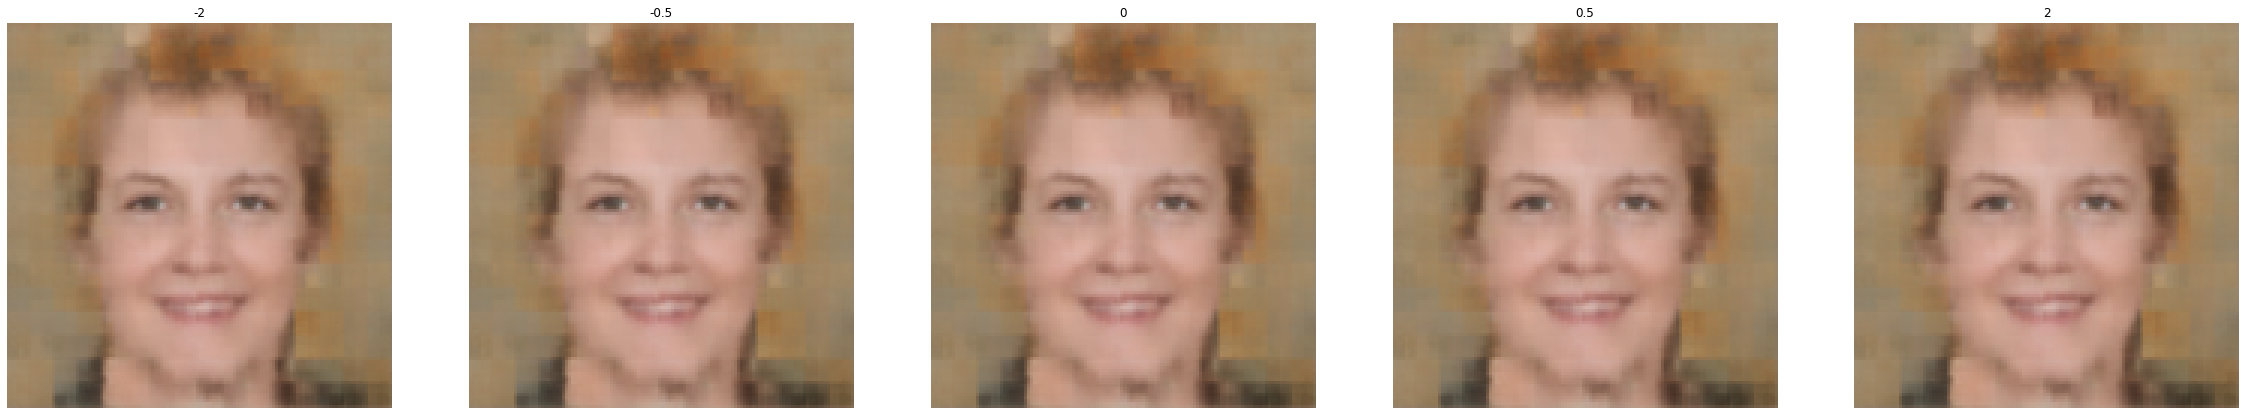

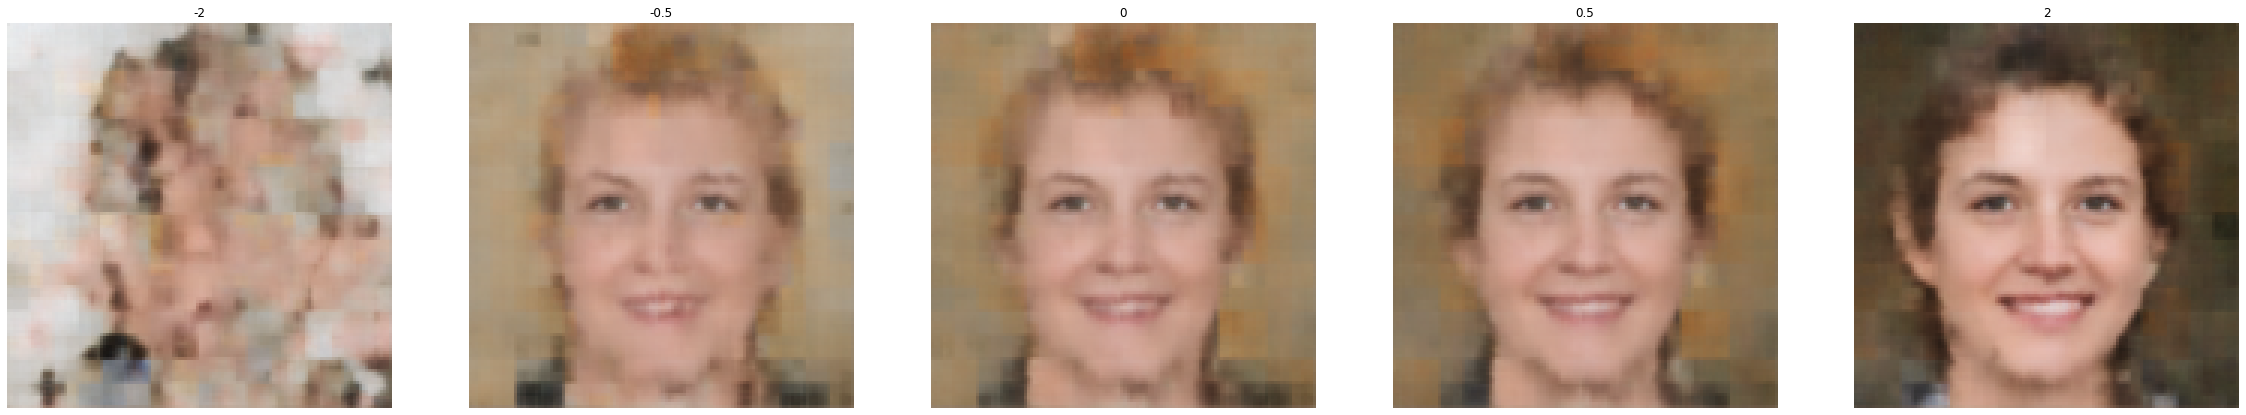

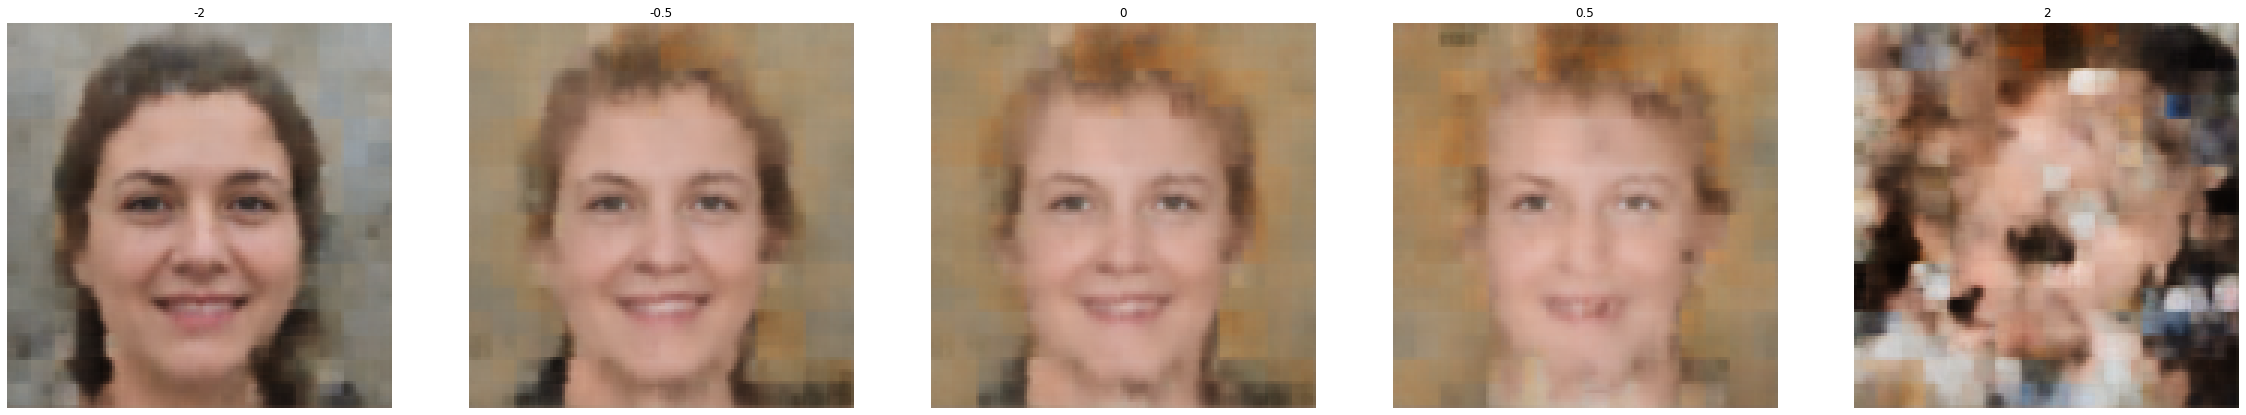

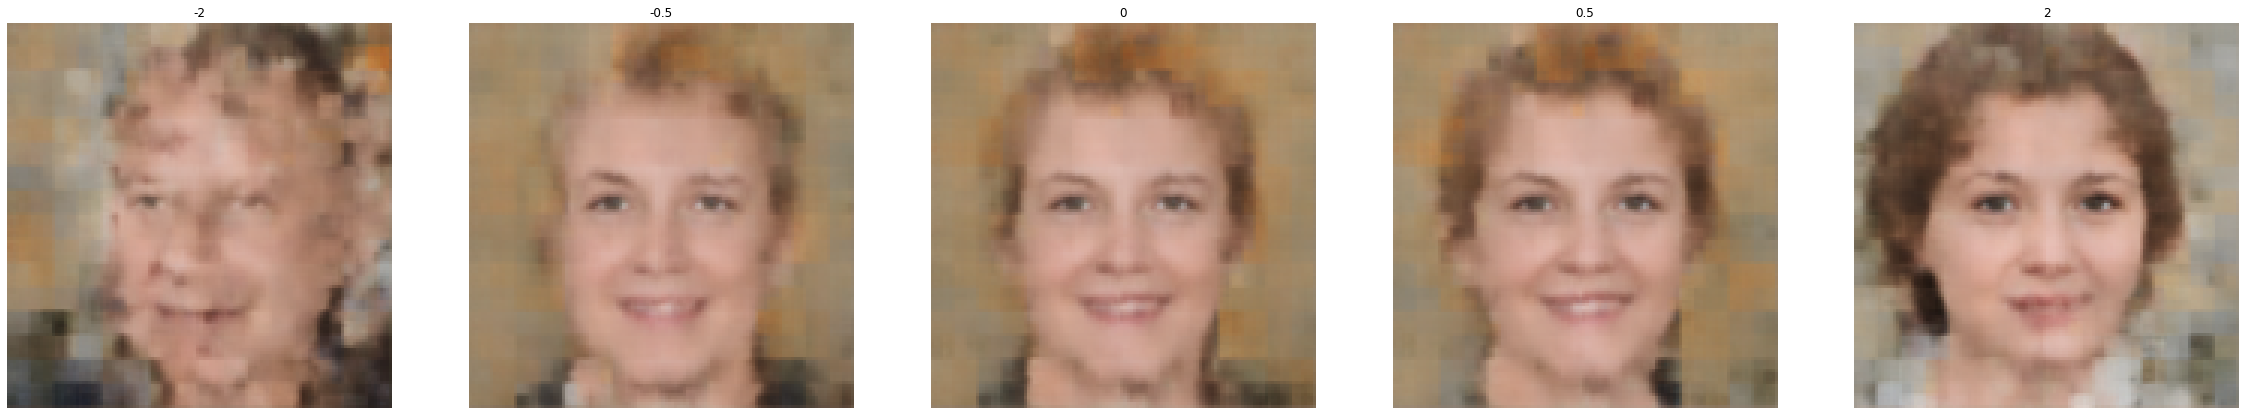

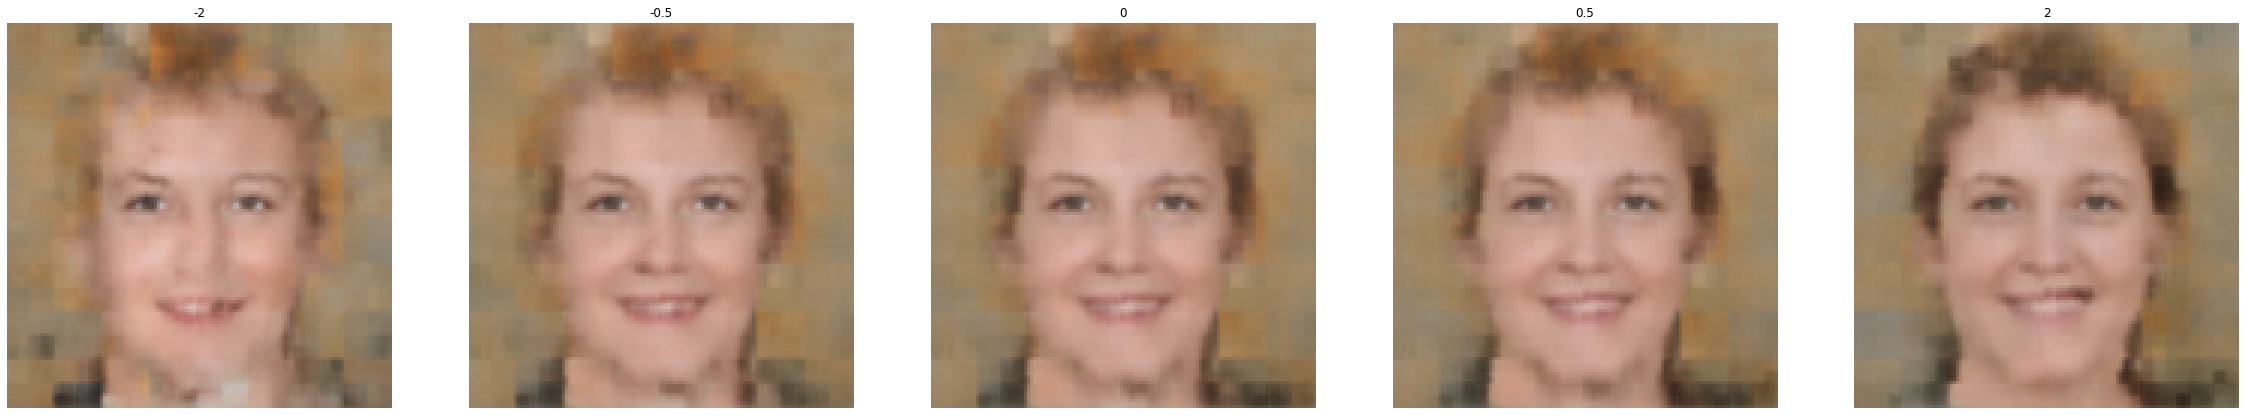

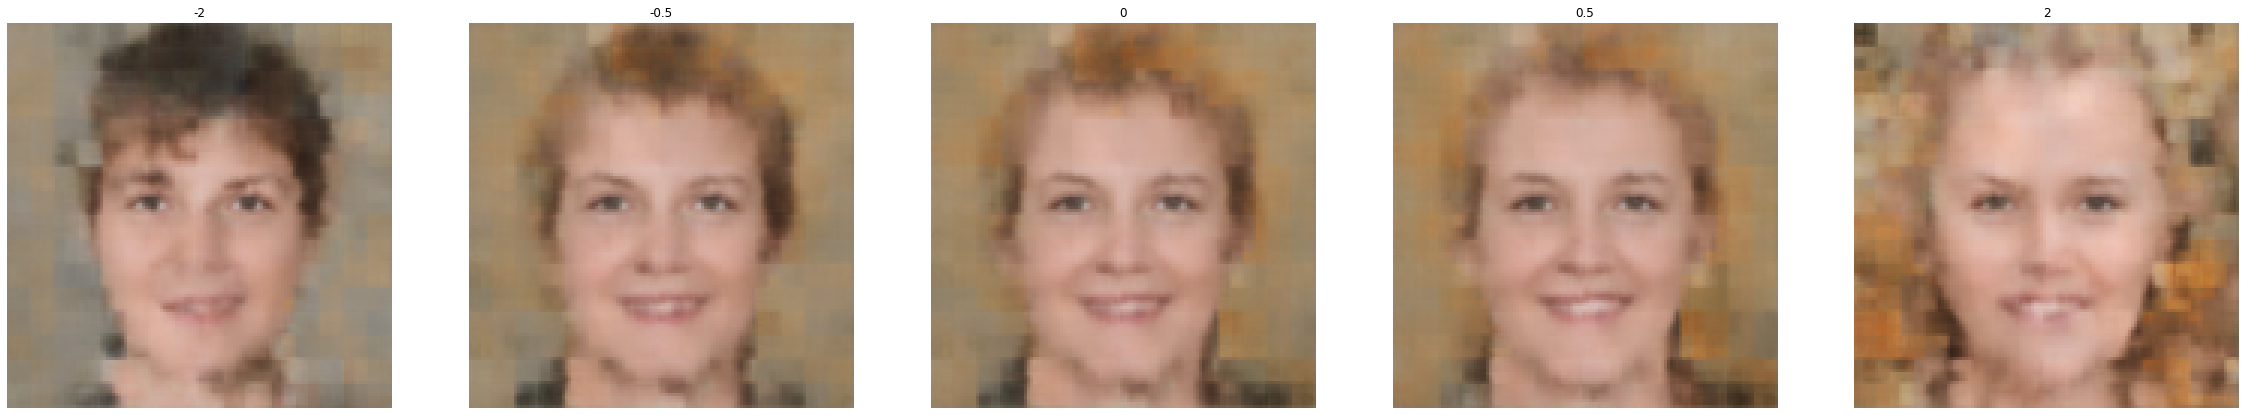

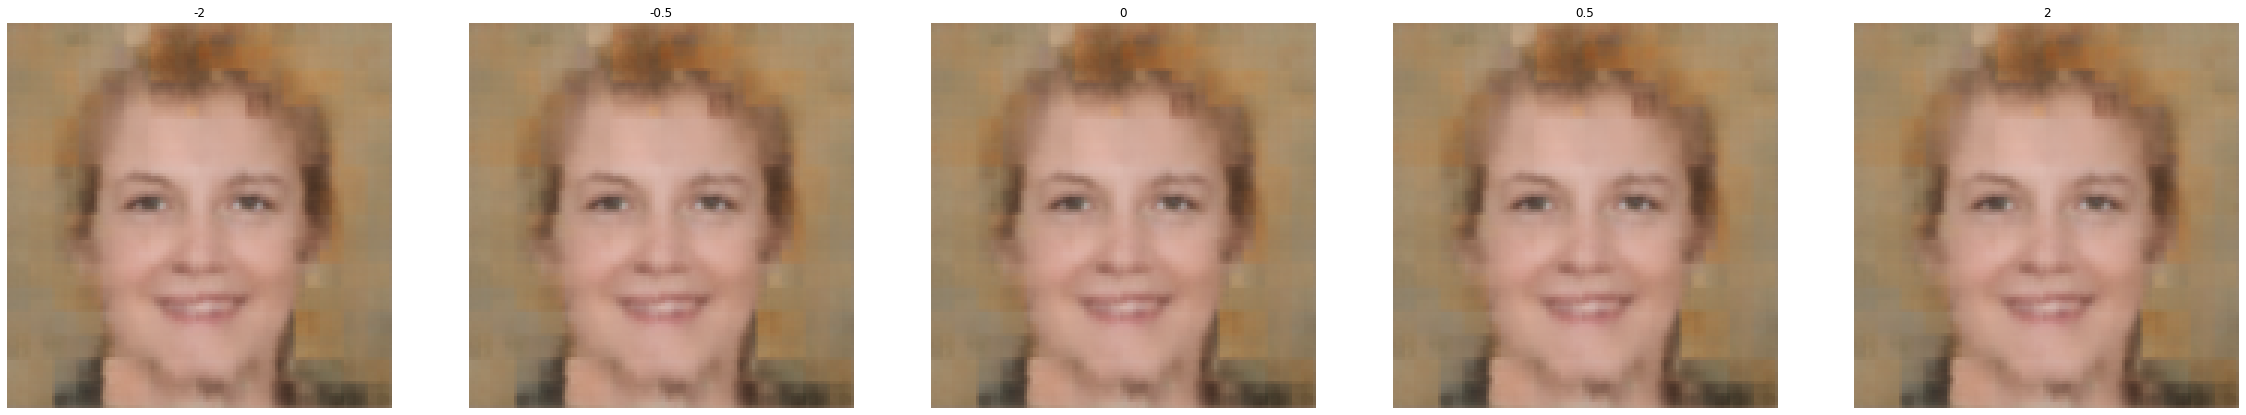

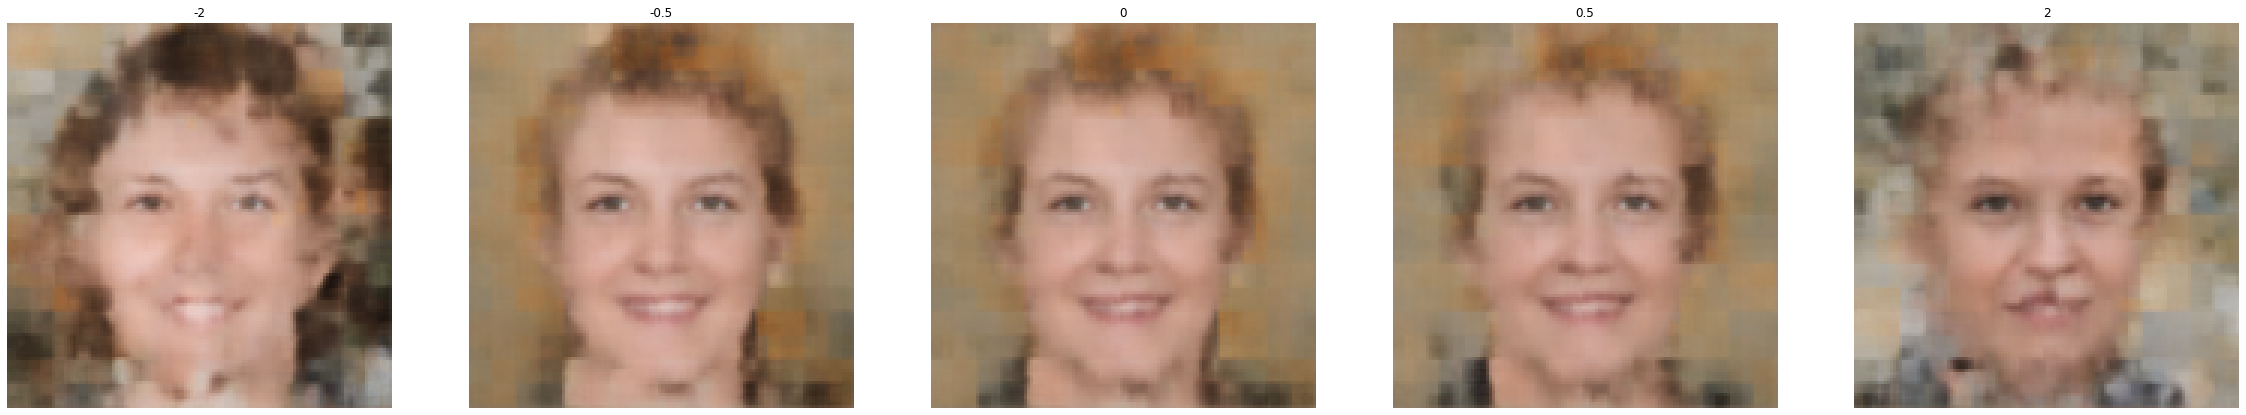

In [18]:
for i in range(16):
    id_card(i, vae_decoder)

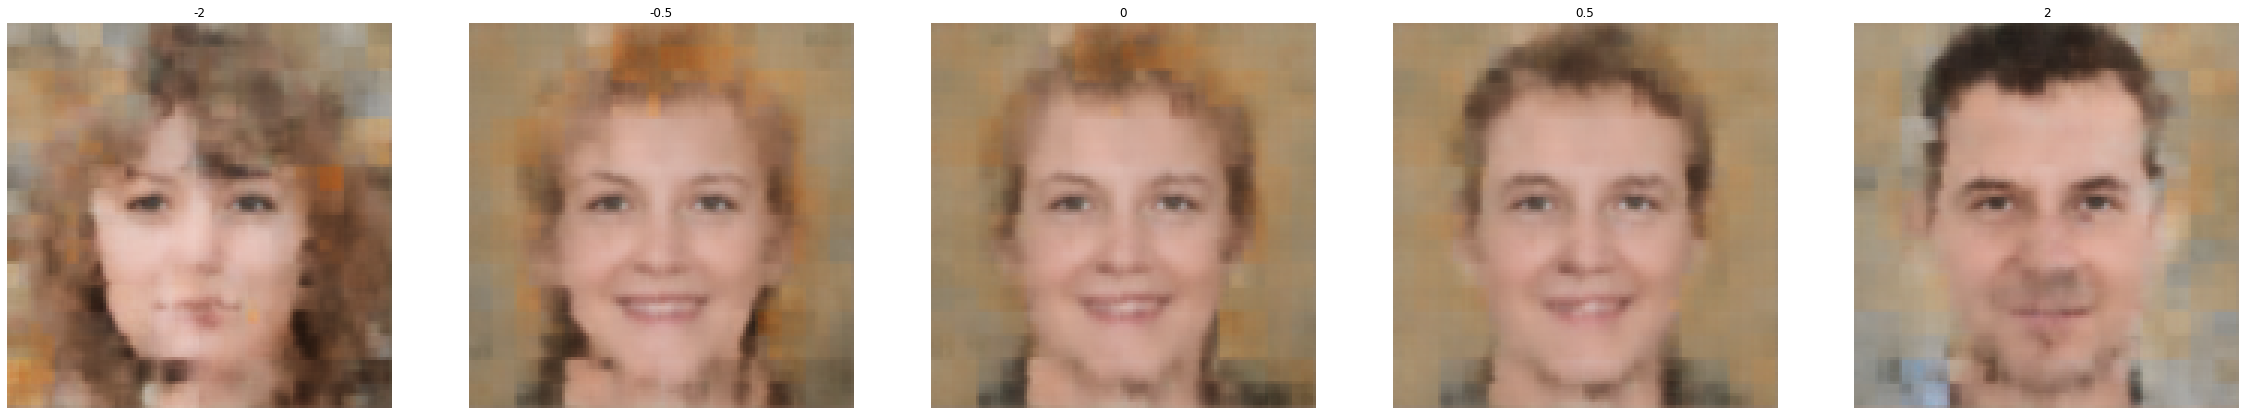

In [37]:
list_images = id_card(3, vae_decoder)

In [39]:
type(list_images)

NoneType